<a href="https://colab.research.google.com/github/LiYuan199701/AMIC/blob/word-level-BAMIC/word_level_wine_BAMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two_layer implementation of AMIC

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompat

# Print out Faster GPUs and Higher Memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Oct  9 15:55:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Basic package loading and import torch

In [ ]:
import pyximport
import os
import IPython
import Cython
import sys
import os
import numpy as np
import pandas as pd
import copy
import scipy
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random, math, sys, string, re
%matplotlib inline
# Set inline backend and resolution
%config InlineBackend.figure_format = 'retina'  # For Retina displays
plt.rcParams['figure.dpi'] = 100  # Set dpi to 200 for high resolution

# Import keras and tensorflow
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing.sequence import pad_sequences

# Split dataset into train, val, test
from sklearn.model_selection import train_test_split

# Import Torch Package and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.__version__

'2.8.0+cu126'

# Mount Google Driver, Read in Data Set from my Google Driver

In [ ]:
%%time
# Mount Google Driver
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Change to my project directory
os.chdir('/content/drive/MyDrive/AMIC project')

# Read in wine review data
df = pd.read_excel('./data/05_16_9reviewer.xlsx', index_col=0)

# Randomly select 2000 rows from df
#df = df.sample(n=3000, random_state=42)

# rename index of ds "Column1" into index
df = df.reset_index()
# rename Column1 into index
df = df.rename(columns={'Column1': 'index'})

import re

# --- Imports ----------------------------------------------------
import re
import unicodedata
import pandas as pd

# --- Helpers: normalize and strip trailing meta -----------------
def _normalize_tail_text(s: str) -> str:
    """Normalize unicode, collapse odd spaces/dashes so regex is robust."""
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("\u00a0", " ")      # NBSP -> space
    s = s.replace("\u2009", " ")      # thin space -> space
    # collapse runs of whitespace
    s = re.sub(r"[ \t\r\f\v]+", " ", s)
    # remove extra space before punctuation in tail segments
    s = re.sub(r"\s+([,;:\.\!\?\-–—])", r"\1", s)
    return s.strip()

# Reusable fragments
YEAR   = r"(?:19|20)\d{2}"                       # 1900–2099
RANGE  = r"(?:-|to|–|—|through|until)"
UNITS  = r"(?:cases?|bottles?|barrels?)"
ABOUT  = r"(?:about|around|approximately|approx\.?|only|just|~|≈)\s*"

# Production/volume tail (e.g., "245 cases made", "760,000 bottles imported")
VOLUME_PART = rf"""
    (?:(?:{ABOUT})?)            # optional 'about/approx'
    \d[\d,\.]*\s*               # number (245, 760,000, 12.5)
    {UNITS}\s*                  # cases/bottles/barrels
    (?:(?:made|imported|produced|bottled|released|crafted)s?)?  # optional verb
"""

# Serving-window tail variants
SERVING_PART = rf"""
    (?:
        (?:drink\s+now(?:\s*(?:{RANGE})\s*{YEAR})?) |
        (?:best\s+after\s+{YEAR}) |
        (?:best\s+(?:from|in|by|through)\s+{YEAR}(?:\s*(?:{RANGE})\s*{YEAR})?) |
        (?:drink\s+{YEAR}(?:\s*(?:{RANGE})\s*{YEAR})?) |
        (?:hold(?:\s+(?:until|through))?\s+{YEAR}) |
        (?:cellar\s+(?:until|through)\s+{YEAR})
    )
"""

# One combined, end-anchored pattern that can strip one or more tail chunks
COMBINED_TAIL_RE = re.compile(
    rf"""
    (?:[.;\s\-–—,])*                       # optional trailing punctuation/space
    (?:
        {SERVING_PART}
        |
        {VOLUME_PART}
    )
    (?:
        (?:[.;\s\-–—,]+)                   # separators between multiple tail chunks
        (?:
            {SERVING_PART}
            |
            {VOLUME_PART}
        )
    )*
    \s*[\.\!\?]*\s*$                       # end of string
    """,
    re.IGNORECASE | re.VERBOSE
)

def strip_trailing_meta(text: str) -> str:
    """
    Remove serving-window and production-volume tails at the very end,
    e.g., 'Drink now through 2020. 245 cases made'.
    Robust to odd spaces/dashes. Loops a few times just in case.
    """
    s = _normalize_tail_text(text)
    for _ in range(3):
        new = COMBINED_TAIL_RE.sub("", s).rstrip()
        if new == s:
            break
        s = new
    return s

# --- Apply to your dataframe -----------------------------------
# Work with pandas' nullable string dtype and keep original intact
orig = df['Clean_desc'].astype('string')
cleaned = orig.fillna('').map(strip_trailing_meta)
df['Clean_desc_clean'] = cleaned.where(orig.notna(), pd.NA)

# (optional) summary of changes
changed = (orig != df['Clean_desc_clean']) & orig.notna()
print(f"Cleaned {changed.sum()} of {len(df)} rows ({changed.mean():.1%}).")

# (optional) peek at a few diffs
df.loc[changed, ['Clean_desc', 'Clean_desc_clean']].head(500)

# (optional) replace in-place and drop the backup column:
# df['Clean_desc'] = df['Clean_desc_clean']
# df.drop(columns=['Clean_desc_clean'], inplace=True)

Mounted at /content/drive
Cleaned 141904 of 141904 rows (100.0%).
CPU times: user 38 s, sys: 204 ms, total: 38.2 s
Wall time: 53.7 s


,Clean_desc,Clean_desc_clean
0,"Smells great, but it's a bit tough and acidic ...","Smells great, but it's a bit tough and acidic ..."
1,Grapey and chocolate flavors mingle in this fi...,Grapey and chocolate flavors mingle in this fi...
2,"Smells of sautéed mushroom, soy and stale ging...","Smells of sautéed mushroom, soy and stale ging..."
3,"Dry, earthy, herbal and dried currant and berr...","Dry, earthy, herbal and dried currant and berr..."
4,Earthy and tilting toward barnyardy. Dry and a...,Earthy and tilting toward barnyardy. Dry and a...
...,...,...
495,"High-toned, with Bing cherry and floral notes....","High-toned, with Bing cherry and floral notes...."
496,"Soft on the edges, showing modest cherry fruit...","Soft on the edges, showing modest cherry fruit..."
497,"Light and slightly crisp, with cherry and cran...","Light and slightly crisp, with cherry and cran..."
498,"Offers a trim band of cherry and berry fruit, ...","Offers a trim band of cherry and berry fruit, ..."


In [ ]:
# sample number of rows to display from df where rating > 95
df[df['rating'] > 95][['rating', 'Clean_desc_clean']].sample(n=500)

,rating,Clean_desc_clean
141802,98,Like a distilled version of the 1971 bouquet--...
141893,99,This manages to take a wide range of fruit—log...
140980,96,"Stunning, with a depth of fruit and minerality..."
141888,99,This offers a beautiful balance between its tw...
141585,97,This powerful red is packed with ripe cherry a...
...,...,...
141714,98,"Terrific focus to this extremely dense 2003, w..."
141084,96,"Gingerbread, honey, dried apricot, quince past..."
141801,98,"There's a unique dark, brooding side to this r..."
141565,97,"A bit of a brute, with a very chewy bitterswee..."


# Pad Size

Total reviews: 141904
Min/Median/Mean/Max length: 3 / 25 / 25.6 / 93

Key quantiles (length in tokens):
 quantile  length
    0.500      25
    0.750      30
    0.900      36
    0.950      39
    0.975      43
    0.990      48
    0.995      52

Coverage by candidate pad_size:
 pad_size  coverage_frac  coverage_%
       64       0.999387       99.94
       80       0.999958      100.00
       96       1.000000      100.00
      100       1.000000      100.00
      112       1.000000      100.00
      120       1.000000      100.00
      128       1.000000      100.00
      144       1.000000      100.00
      150       1.000000      100.00
      160       1.000000      100.00
      192       1.000000      100.00
      200       1.000000      100.00
      224       1.000000      100.00
      256       1.000000      100.00

Suggested pad_size:
  • ~90% coverage: 40
  • ~95% coverage: 40  ← common trade-off
  • ~99% coverage: 48  (larger memory/compute)


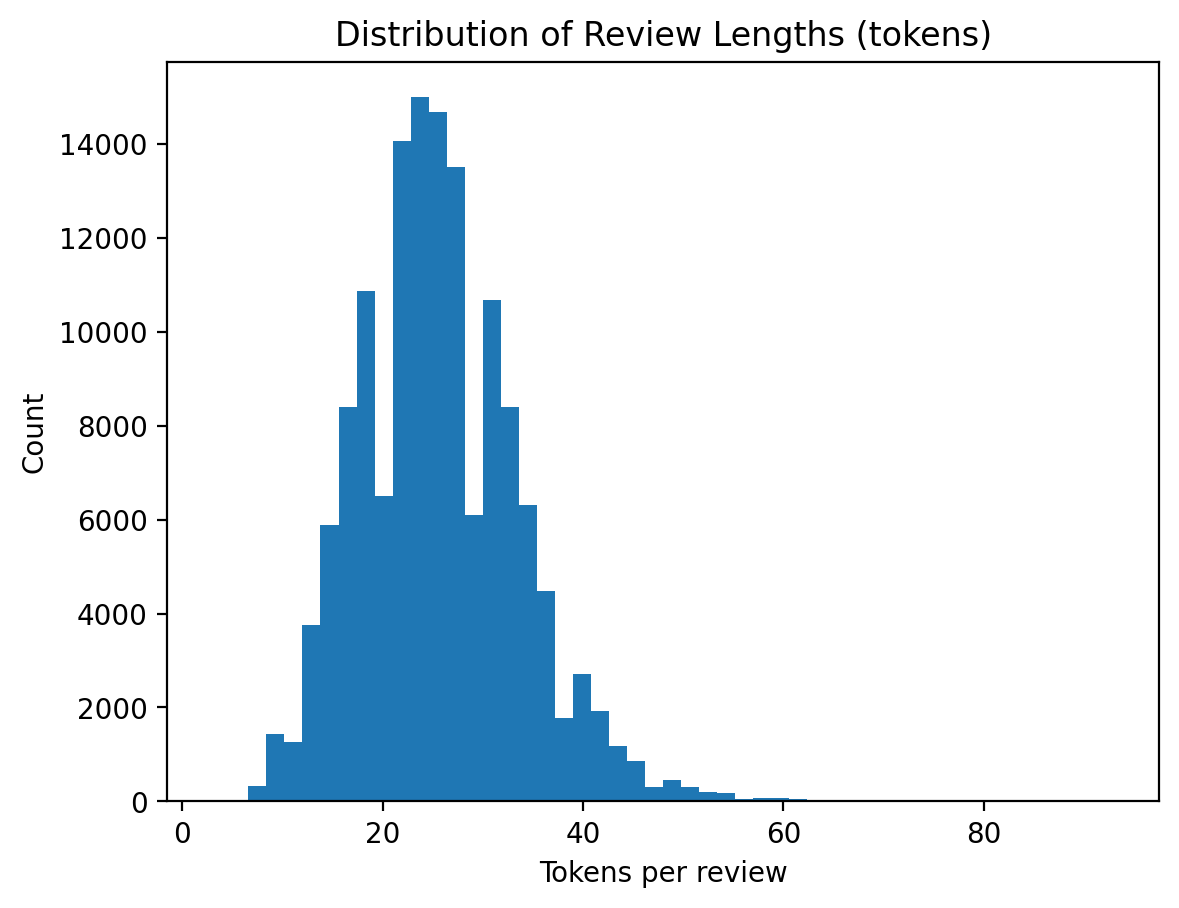

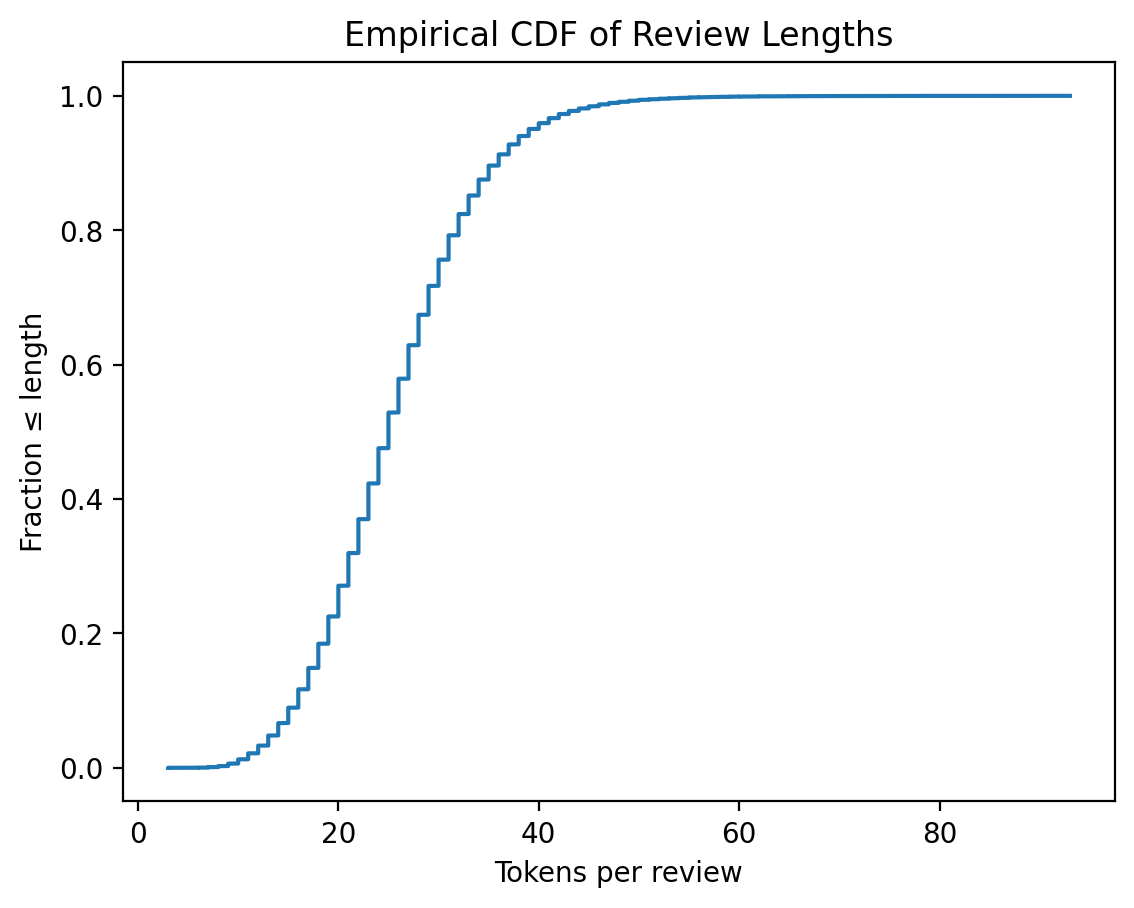

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) compute token lengths (simple whitespace tokenization) ---
texts = df["Clean_desc_clean"].astype(str).fillna("")
lengths = texts.apply(lambda s: len(s.split()))
lengths_np = lengths.to_numpy()

print(f"Total reviews: {len(lengths_np)}")
print(f"Min/Median/Mean/Max length: {lengths_np.min()} / {np.median(lengths_np):.0f} / {lengths_np.mean():.1f} / {lengths_np.max()}")

# --- 2) helpful percentiles ---
qs = [0.50, 0.75, 0.90, 0.95, 0.975, 0.99, 0.995]
perc = np.quantile(lengths_np, qs).astype(int)
perc_table = pd.DataFrame({"quantile": qs, "length": perc})
print("\nKey quantiles (length in tokens):")
print(perc_table.to_string(index=False))

# --- 3) candidate pad sizes and coverage ---
candidates = [64, 80, 96, 100, 112, 120, 128, 144, 150, 160, 192, 200, 224, 256]
coverage = [ (lengths_np <= c).mean() for c in candidates ]
cov_table = pd.DataFrame({"pad_size": candidates, "coverage_frac": coverage})
cov_table["coverage_%"] = (cov_table["coverage_frac"]*100).round(2)
print("\nCoverage by candidate pad_size:")
print(cov_table.to_string(index=False))

def round_up_to_multiple(x, m=8):
    return int(np.ceil(x / m) * m)

# suggest sizes: cover 90/95/99% (rounded up to nearest 8)
p90, p95, p99 = np.quantile(lengths_np, [0.90, 0.95, 0.99])
suggest_90 = round_up_to_multiple(p90, 8)
suggest_95 = round_up_to_multiple(p95, 8)
suggest_99 = round_up_to_multiple(p99, 8)

print(f"\nSuggested pad_size:")
print(f"  • ~90% coverage: {suggest_90}")
print(f"  • ~95% coverage: {suggest_95}  ← common trade-off")
print(f"  • ~99% coverage: {suggest_99}  (larger memory/compute)")

# --- 4) plots ---

# Histogram (distribution of lengths)
plt.figure()
plt.hist(lengths_np, bins=50)
plt.title("Distribution of Review Lengths (tokens)")
plt.xlabel("Tokens per review")
plt.ylabel("Count")
plt.show()

# Empirical CDF (what fraction fits under each length)
sorted_len = np.sort(lengths_np)
ecdf = np.arange(1, len(sorted_len)+1) / len(sorted_len)

plt.figure()
plt.plot(sorted_len, ecdf)
plt.title("Empirical CDF of Review Lengths")
plt.xlabel("Tokens per review")
plt.ylabel("Fraction ≤ length")
plt.show()

# The Whole Pre-Process the Dataset

train index:  [126513, 96328, 51255, 19448, 102796, 48044, 79800, 134806, 63750, 41011]
valid index:  [24564, 59663, 40114, 7348, 23132, 137269, 37609, 21133, 104607, 53387]
test index:  [105204, 28729, 100785, 16531, 109056, 68712, 1011, 63878, 134761, 117623]
Loaded 400000 word vectors from glove.
Found 11676 unique tokens. 

(11676, 300) 

Word Index list:  ['and', 'with', 'a', 'the', 'of'] 

Wine Sentence Token:  [['a', 'superflashy', 'style', 'boasting', 'lots', 'of', 'melted', 'licorice', 'fruitcake', 'fig', 'paste', 'and', 'black', 'currant', 'preserve', 'flavors', 'which', 'all', 'stay', 'pure', 'and', 'focused', 'on', 'the', 'creamy', 'lengthy', 'finish', 'a', "hedonist's", 'delight']] 

Found 9802 unique tokens.
(9802, 300)
Show length vector:  [[28]
 [17]
 [30]
 ...
 [28]
 [29]
 [25]] 

Show token id for 1st sentence:  [3, 46, 611, 209, 5, 535, 43, 488, 95, 326, 1, 19, 30, 1323, 7, 134, 166, 510, 119, 1, 64, 10, 4, 89, 695, 6, 3, 2628] 

Show the Max token id of all corpus: 

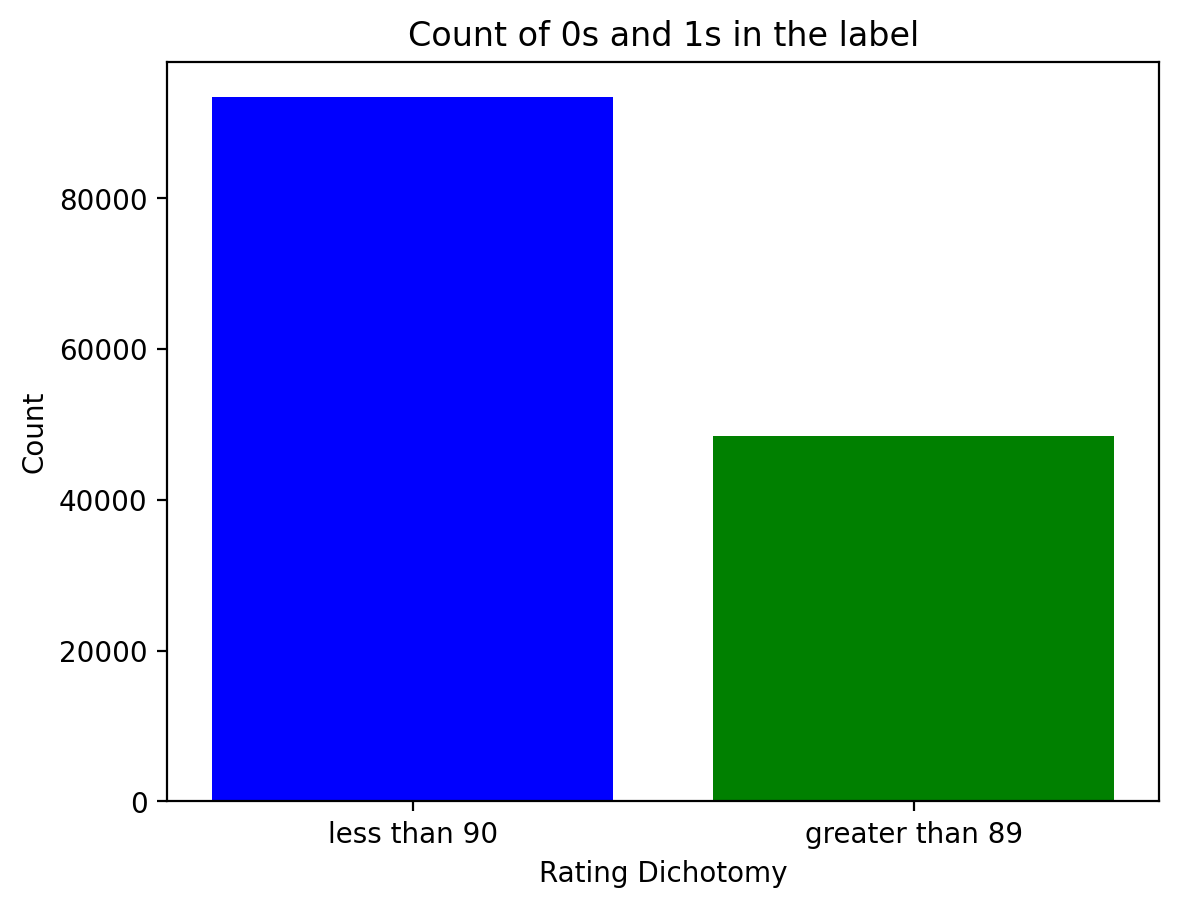

<Figure size 700x400 with 0 Axes>

outcome y label length:  141904 

Print padded Embedding shape:  (141904, 50) 

Attention mask shape:  (141904, 50) 

train_x shape:  (127713, 51)
train_y shape:  (127713,)
valid_x shape:  (7095, 51)
valid_y shape:  (7095,)
test_x shape:  (7096, 51)
test_y shape:  (7096,)
Sample X size: torch.Size([64, 51])
Sample Y size: torch.Size([64])
Sample rating size: torch.Size([64])
First ratings in batch: tensor([94, 90, 88, 86, 85, 87, 86, 86, 90, 89], dtype=torch.int32)
Embedding Size:  300 

Embedding Matrix Size:  (9802, 300) 

Embedding Matrix size with zero (9803, 300)
CPU times: user 46.5 s, sys: 1.46 s, total: 48 s
Wall time: 49.3 s


In [ ]:
%%time
# Split Dataset================================================================
#==============================================================================
# Shuffle the wine review dataset
ds=df.sample(frac=1, random_state=42).copy()

y = (ds['rating']>89).astype(int).values
# assign column Sentiment to be y
#y = ds['Sentiment'].values

# Keep the raw rating (80–100) for analysis
ratings = ds['rating'].to_numpy().astype(np.int16)

# Set a seed to torch functions for reproduce
SEED = 2022
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

indices = range(len(y))
train_index, valid_index = train_test_split(indices, test_size=0.1, random_state = SEED)
valid_index, test_index = train_test_split(valid_index, test_size=0.5, random_state = SEED)
print("train index: ", train_index[:10])
print("valid index: ", valid_index[:10])
print("test index: ", test_index[:10])

# Get the train, dev and test ratings
train_r = ratings[list(train_index)]
valid_r = ratings[list(valid_index)]
test_r  = ratings[list(test_index)]

# Preprocess the dataset ======================================================
#==============================================================================

## Creat a tokenizer object and word index
#==============================================================================
# assign a string to be indicated as a variable name
text_col = 'Clean_desc_clean'
#text_col = 'processed_text'
#tokenizer = Tokenizer(num_words=max_features)
maxlen=150
tokenizer = Tokenizer()
#Indexing words based on the whole corpus (prior to split)
tokenizer.fit_on_texts(ds[text_col])
#tokenizer.fit_on_texts(ds['Clean_desc'])
#tokenizer.fit_on_texts(ds['clean_desc_v5'])
wine_corpus= tokenizer.texts_to_sequences(ds[text_col])
#wine_corpus= tokenizer.texts_to_sequences(ds['Clean_desc'])
#wine_corpus= tokenizer.texts_to_sequences(ds['clean_desc_v5'])
train_word_index=tokenizer.word_index

## Create an id and word dictionary
#==============================================================================
tokenizer.word_index
wine_id2word=dict(zip(tokenizer.word_index.values(),tokenizer.word_index.keys()))
# Display
dict(list(wine_id2word.items())[:10])

## Initialize a word embedding dictionary with a pretrained word embedding file
#==============================================================================
import os
import numpy as np
import pickle
from gensim.models import Word2Vec, FastText

def load_embeddings(kind: str, path: str):
    """
    Load word embeddings of various types into a dict {word: vector}.

    Parameters
    ----------
    kind : str
        One of: 'glove', 'word2vec', 'fasttext', 'bert'.
    path : str
        For 'glove': path to the glove .txt file.
        For 'word2vec': path to the .model file.
        For 'fasttext': path to the .model file.
        For 'bert': path to the pickle .pkl file containing a dict {word: array}.

    Returns
    -------
    embeddings_index : dict
        Mapping from token to its embedding (np.array of dtype float32).
    """
    embeddings_index = {}

    if kind == 'glove':
        # e.g. path = './word_embedding/glove.6B.300d.txt'
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.rstrip().split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

    elif kind == 'word2vec':
        # e.g. path = './word_embedding/wine_review_word2vec.model'
        model = Word2Vec.load(path)
        for word in model.wv.index_to_key:
            embeddings_index[word] = model.wv[word].astype('float32')

    elif kind == 'fasttext':
        # e.g. path = './word_embedding/wine_review_fasttext.model'
        model = FastText.load(path)
        for word in model.wv.index_to_key:
            embeddings_index[word] = model.wv[word].astype('float32')

    elif kind == 'bert':
        # e.g. path = './word_embedding/bert_embeddings.pkl'
        with open(path, 'rb') as f:
            unique_word_embeddings = pickle.load(f)
        for word, emb in unique_word_embeddings.items():
            embeddings_index[word] = np.asarray(emb, dtype='float32')

    else:
        raise ValueError(f"Unknown embedding kind: {kind!r}. "
                         "Choose from 'glove', 'word2vec', 'fasttext', 'bert'.")

    print(f"Loaded {len(embeddings_index)} word vectors from {kind}.")
    return embeddings_index

#EMB_KIND = 'word2vec'        # or 'word2vec', 'fasttext', 'bert'
EMB_KIND = 'glove'
#EMB_PATH = 'fasttext'
#EMB_KIND = 'bert'
#EMB_PATH = './word_embedding/bert_embeddings.pkl'
EMB_PATH = './word_embedding/glove.6B.300d.txt'
#EMB_PATH = './word_embedding/wine_review_word2vec.model'
#EMB_PATH = './word_embedding/wine_review_fasttext.model'
embeddings_index = load_embeddings(EMB_KIND, EMB_PATH)

## Create an embedding matrix for unique words
# =============================================================================
#embedding_size=50
# write code to adjust the embedding_size to 768 when EMB_KIND is bert otherwise 300
if EMB_KIND == 'glove':
    embedding_size = 300
elif EMB_KIND == 'word2vec':
    embedding_size = 300
elif EMB_KIND == 'fasttext':
    embedding_size = 300
elif EMB_KIND == 'bert':
    embedding_size = 768
word_index = list(tokenizer.word_index.keys())
miss_index =[]
miss_word = []
print('Found %s unique tokens.' % len(word_index), "\n")

embedding_matrix = np.zeros((len(word_index), embedding_size))
for i,word in enumerate(word_index):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
      # words not found in embedding index will be all-zeros.
        miss_word.append(word)
        miss_index.append(i)
print(embedding_matrix.shape, "\n")
print("Word Index list: ", word_index[:5], "\n")

## Convert Corpus ids into words
# ============================================================================
#changed to 1 index
new_index = [x for x in list(range(len(word_index))) if x not in miss_index]
new_vocab = [x for x in list(word_index) if x not in miss_word]
new_vocab_dict = dict(zip(new_vocab,range(1,len(new_vocab)+1)))

def sent_id2word(corpus,id2word):
    output=[]
    for doc in corpus:
        temp = [id2word.get(x) for x in doc]
        output.append(temp)
    return output

wine_sents = sent_id2word(wine_corpus,wine_id2word)
# Demo for 1st sentence tokoen sequence
print("Wine Sentence Token: ", wine_sents[:1], "\n")

## Remove words that are not in embedding matrix
# =============================================================================
## remove word in not in the embedding matrix
new_wine_sents = []
new_vocab_id2word = dict(zip(new_vocab_dict.values(),new_vocab_dict.keys()))

for doc in wine_sents:
    temp = [x for x in doc if x in new_vocab]
    new_wine_sents.append(temp)
## retokenize with new_vocab_dict that is zero indexed
new_wine_sents_id = []
for doc in new_wine_sents:
    temp = [new_vocab_dict.get(x) for x in doc]
    new_wine_sents_id.append(temp)

new_wine_sents[0]

## Make a new embedding matrix for all existing words
# =============================================================================
word_index = list(new_vocab_dict.keys())
miss_index =[]
miss_word = []
print('Found %s unique tokens.' % len(word_index))


embedding_matrix = np.zeros((len(word_index), embedding_size))
for i,word in enumerate(word_index):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        miss_word.append(word)
        miss_index.append(i)
print(embedding_matrix.shape)

## Calculate the word length for each review
# =============================================================================
Corpus_cleaned = new_wine_sents
Corpus_cleaned_id = new_wine_sents_id
lengths = [len(x) for x in Corpus_cleaned_id]
lengths = np.array(lengths)
lengths = np.expand_dims(lengths, axis=1)
#nsize=5000
#text_10000 = Corpus_cleaned_id[0:nsize]+ Corpus_cleaned_id[::-1][0:nsize]
text_10000 = Corpus_cleaned_id

print("Show length vector: ", lengths, "\n")
print("Show token id for 1st sentence: ", Corpus_cleaned_id[0], "\n")
print("Show the Max token id of all corpus: ", max([max(x) for x in Corpus_cleaned_id]), "\n")

## Plot a bar plot to show the distribution of y label
# =============================================================================
# Counting 1s and 0s
num_ones = np.count_nonzero(y)
num_zeros = y.size - num_ones

# Data for plotting
counts = [num_zeros, num_ones]
labels = ['less than 90', 'greater than 89']

# Creating bar plot
plt.bar(labels, counts, color=['blue', 'green'])

# Adding title and labels
plt.title('Count of 0s and 1s in the label')
plt.xlabel('Rating Dichotomy')
plt.ylabel('Count')
plt.xticks(labels)

# Showing the plot
plt.figure(figsize=(7, 4))
plt.show()

## Define a function that either pads a review with zeros or truncate to a specific length
# =============================================================================
def pad_features(reviews_int, seq_length):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]

        features[i,:] = np.array(new)

    return features


## Define a function that right-pads with PAD=0 and also returns an attention mask
# =============================================================================
def pad_and_mask_features(reviews_int, seq_length):
    """
    Right-pad sequences with 0s up to seq_length; truncate longer sequences on the right.
    Returns:
      features:  int32 array [N, seq_length] of token ids (0 = PAD)
      attn_mask: int8  array [N, seq_length] with 1 for real tokens, 0 for PADs
    """
    N = len(reviews_int)
    features = np.zeros((N, seq_length), dtype=np.int64)
    attn_mask = np.zeros((N, seq_length), dtype=np.int8)

    for i, review in enumerate(reviews_int):
        if not review:
            continue
        if len(review) <= seq_length:
            # RIGHT-PAD: write tokens first, then zeros
            L = len(review)
            features[i, :L] = np.asarray(review, dtype=np.int64)
            attn_mask[i, :L] = 1
        else:
            # truncate on the right
            features[i, :] = np.asarray(review[:seq_length], dtype=np.int64)
            attn_mask[i, :] = 1
    return features, attn_mask

## Apply sequence length of 100 to uniform the all review lengths
# ============================================================================
pad_size = 50
padded_X, attn_masks = pad_and_mask_features(text_10000, pad_size)
print("outcome y label length: ", len(y), "\n")
print("Print padded Embedding shape: ", padded_X.shape, "\n")
print("Attention mask shape: ", attn_masks.shape, "\n")

## Split the whole dataset into training, validation, and test: 18:1:1
# ============================================================================
train_x = np.concatenate([padded_X[train_index],lengths[train_index]],axis = 1)
valid_x = np.concatenate([padded_X[valid_index],lengths[valid_index]],axis = 1)
test_x = np.concatenate([padded_X[test_index],lengths[test_index]],axis = 1)

train_y = (y[train_index])
valid_y = (y[valid_index])
test_y = (y[test_index])

print("train_x shape: ", train_x.shape)
print("train_y shape: ", train_y.shape)
print("valid_x shape: ", valid_x.shape)
print("valid_y shape: ", valid_y.shape)
print("test_x shape: ", test_x.shape)
print("test_y shape: ", test_y.shape)

## Convert Pandas frame into a Tensor datasets and Tensor Dataset into DataLoader with a batch size of 64
# =============================================================================
# Convert to tensors (inputs=int64, labels=float32, ratings=int16->int32)
train_inputs = torch.from_numpy(train_x.astype(np.int64))
valid_inputs = torch.from_numpy(valid_x.astype(np.int64))
test_inputs  = torch.from_numpy(test_x.astype(np.int64))

train_labels = torch.from_numpy(train_y.astype(np.float32))
valid_labels = torch.from_numpy(valid_y.astype(np.float32))
test_labels  = torch.from_numpy(test_y.astype(np.float32))

train_ratings = torch.from_numpy(train_r.astype(np.int32))
valid_ratings = torch.from_numpy(valid_r.astype(np.int32))
test_ratings  = torch.from_numpy(test_r.astype(np.int32))

# Now each sample yields: (inputs, label, rating)
train_data = TensorDataset(train_inputs, train_labels, train_ratings)
valid_data = TensorDataset(valid_inputs, valid_labels, valid_ratings)
test_data  = TensorDataset(test_inputs,  test_labels,  test_ratings)

batch_size = 64
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_loader  = DataLoader(test_data,  shuffle=False, batch_size=batch_size, drop_last=True)

## Obtain one batch of training data for demo display
# ============================================================================
dataiter = iter(train_loader)
sample_x, sample_y, sample_rating = next(dataiter)
print('Sample X size:', sample_x.size())      # [B, pad_size + 1]
print('Sample Y size:', sample_y.size())      # [B]
print('Sample rating size:', sample_rating.size())  # [B]
print('First ratings in batch:', sample_rating[:10])

## Define a function that creates an embedding layer object (PAD index = 0)
# =============================================================================
def create_emb_layer(weights_matrix: torch.Tensor, non_trainable: bool = False):
    """
    weights_matrix: torch.FloatTensor of shape [vocab_size_with_pad, embedding_dim]
                    row 0 must be the PAD embedding (zeros recommended).
    """
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding.from_pretrained(
        weights_matrix,
        freeze=non_trainable,
        padding_idx=0   # ensures PAD row stays zeroed and ignored in gradients
    )
    return emb_layer, num_embeddings, embedding_dim

## Create a padded embedding matrix
# ============================================================================
print("Embedding Size: ", embedding_size, "\n")
print("Embedding Matrix Size: ", embedding_matrix.shape, "\n")
pad_embedding_matrix=np.concatenate((np.zeros(embedding_size).reshape(1,embedding_size), embedding_matrix),axis=0)
print("Embedding Matrix size with zero", pad_embedding_matrix.shape)
pad_embedding_matrix = torch.from_numpy(pad_embedding_matrix.astype(np.float32))

## Convert the tensor of token ID back to the word by the dictionary
# ============================================================================
# Convert the tensor of token ID back to the word by the dictionary
def sent_id2word(corpus, id2word):
    output=[]
    for doc in corpus:
        temp = [id2word.get(x) for x in doc]
        output.append(temp)
    return output

# Define a function that maps each token id to the word from a single tensor object
def rev_id2word(doc, id2word):
    return [id2word.get(x) for x in doc]

# Apply the sentence id to word function to the first part of each of dataiter
# rev_id2word(train_x[0], wine_id2word)

# Apply sent_id2word function to the train_data
word_train = sent_id2word(padded_X[train_index], wine_id2word)

# Bayesian AMIC structure

In [ ]:
#%%writefile models/models.py
import numpy as np
import pandas as pd
import copy
import scipy
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random, math, sys, string, re
# Import Torch Package and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch
import torch.nn as nn
import torch.nn.functional as F


# =========================
# 2) Bayesian last-layer pieces
# =========================
# --- add (or keep) a BayesLinear ---
class BayesLinear(nn.Module):
    """Factorized Gaussian posterior; prior N(0, sigma_p^2 I)."""
    def __init__(self, in_features, out_features, prior_sigma=1.0, init_rho=-3.0):
        super().__init__()
        self.weight_mu  = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.full((out_features, in_features), float(init_rho)))
        self.bias_mu    = nn.Parameter(torch.zeros(out_features))
        self.bias_rho   = nn.Parameter(torch.full((out_features,), float(init_rho)))
        self.register_buffer("prior_sigma", torch.tensor(float(prior_sigma)))

    @property
    def weight_sigma(self): return F.softplus(self.weight_rho) + 1e-8
    @property
    def bias_sigma(self):   return F.softplus(self.bias_rho)   + 1e-8

    def kl(self) -> torch.Tensor:
        w_mu, w_sigma = self.weight_mu, self.weight_sigma
        b_mu, b_sigma = self.bias_mu,   self.bias_sigma
        p_sigma = self.prior_sigma
        kl_w = torch.log(p_sigma / w_sigma) + (w_sigma**2 + w_mu**2) / (2 * p_sigma**2) - 0.5
        kl_b = torch.log(p_sigma / b_sigma) + (b_sigma**2 + b_mu**2) / (2 * p_sigma**2) - 0.5
        return kl_w.sum() + kl_b.sum()

    def forward(self, x, sample: bool = True):
        # x: [..., in_features]
        if self.training or sample:
            W = self.weight_mu + self.weight_sigma * torch.randn_like(self.weight_mu)
            B = self.bias_mu   + self.bias_sigma   * torch.randn_like(self.bias_mu)
        else:
            W, B = self.weight_mu, self.bias_mu
        return F.linear(x, W, B)


# -------------------------------------------------------------------
# create_emb_layer
# -------------------------------------------------------------------
def create_emb_layer(weights_matrix, non_trainable=False):

    num_embeddings, embedding_dim = pad_embedding_matrix.size()
    emb_layer = nn.Embedding.from_pretrained(pad_embedding_matrix)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

# -------------------------------------------------------------------
# Self‐Attention
# -------------------------------------------------------------------
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    """
    Multi-head self-attention with standard scaling by 1/sqrt(S),
    where S = emb // heads is the per-head dimensionality.

    Args:
        emb (int): token embedding size E.
        heads (int): number of attention heads H.
        mask (bool): if True, apply causal masking (no attending to future tokens).
        reduced_dim (int|None): optional projection size after attention.
        attn_dropout (float): dropout on attention weights.
        proj_dropout (float): dropout on the unified head output.
    """
    def __init__(self, emb, heads=8, mask=False, reduced_dim=None,
                 attn_dropout=0.10, proj_dropout=0.20):
        super().__init__()
        assert emb % heads == 0, (
            f'Embedding dimension ({emb}) should be divisible by nr. of heads ({heads})'
        )

        self.emb   = emb
        self.heads = heads
        self.mask  = mask

        # Linear projections to K, Q, V (E -> E), no bias (common choice)
        self.tokeys    = nn.Linear(emb, emb, bias=False)
        self.toqueries = nn.Linear(emb, emb, bias=False)
        self.tovalues  = nn.Linear(emb, emb, bias=False)

        # After concatenating heads back to E, mix them
        self.unifyheads = nn.Linear(emb, emb, bias=True)

        # Optional final projection E -> reduced_dim
        self.projection = nn.Linear(emb, reduced_dim, bias=True) if reduced_dim is not None else None

        # Optional dropouts
        self.attn_drop = nn.Dropout(attn_dropout) if attn_dropout > 0 else nn.Identity()
        self.proj_drop = nn.Dropout(proj_dropout) if proj_dropout > 0 else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, E)
        returns: (B, T, E) or (B, T, reduced_dim) if projection is used
        """
        B, T, E = x.size()
        H = self.heads
        assert E == self.emb, f'Input embedding dim ({E}) should match layer embedding dim ({self.emb})'
        S = E // H  # per-head size

        # Project to K, Q, V: (B,T,E)
        K = self.tokeys(x)
        Q = self.toqueries(x)
        V = self.tovalues(x)

        # Reshape to heads: (B,H,T,S)
        K = K.view(B, T, H, S).transpose(1, 2).contiguous()
        Q = Q.view(B, T, H, S).transpose(1, 2).contiguous()
        V = V.view(B, T, H, S).transpose(1, 2).contiguous()

        # Scaled dot-product attention: scores (B,H,T,T)
        # Scale by sqrt(S) — the standard Transformer choice
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(S)

        # Optional causal mask: disallow attending to future positions
        if self.mask:
            # mask shape (T,T), True where we want to mask (upper triangle)
            causal_mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
            scores = scores.masked_fill(causal_mask, float('-inf'))

        # Softmax over keys dimension, then dropout on weights
        attn = F.softmax(scores, dim=-1)
        attn = self.attn_drop(attn)

        # Weighted sum of values -> (B,H,T,S)
        out = torch.matmul(attn, V)

        # Merge heads: (B,T,E)
        out = out.transpose(1, 2).contiguous().view(B, T, E)

        # Mix heads, optional dropout
        out = self.unifyheads(out)
        out = self.proj_drop(out)

        # Optional final projection: (B,T,reduced_dim)
        if self.projection is not None:
            out = self.projection(out)

        return out

# ------------------------------------------------------------
# tiedLinear
# ------------------------------------------------------------
class tiedLinear(nn.Module):
    def __init__(self, in_features, bias=True):
        super(tiedLinear, self).__init__()
        self.in_features = in_features
        self.weight = Parameter(torch.Tensor(in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(1))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(0))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        repeated_weight = self.weight.repeat(self.in_features, 1)
        return F.linear(input, repeated_weight, self.bias)


# -------------------------------------------------------------------
# PositionalEncoding
# -------------------------------------------------------------------
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


# -------------------------------------------------------------------
# Mask_block
# -------------------------------------------------------------------
class Mask_block(nn.Module):
    """
    Learned token mask head with numerically stable logits:
      1) Feature -> Linear -> raw logits (per token)
      2) Per-sequence standardization: (raw - mean)/std
      3) Global learnable scale & bias
      4) Sigmoid -> (0,1) mask_out, then zero on pads

    Returns:
      mask_out: [B,T] in (0,1)
      p1:       [B]   sum of mask_out per sequence
      p3:       [B]   ((m*(1-m))^2).sum per sequence (peaks at 0.5)
      mean_mask: Python float (mask_out mean) for logging
    """

    def __init__(self, vocab_size, weight_matrix, hidden_dim, n_layers,
                 max_relative_position=2, pivot=0.5, drop_prob=0.5,
                 num_heads=1, reduced_dim=100, temperature=1.0,
                 clip_logits: bool = False, clip_value: float = 8.0):
        super().__init__()

        self.n_layers   = n_layers
        self.hidden_dim = hidden_dim
        self.num_heads  = num_heads
        self.pivot      = float(pivot)          # target initial coverage (pre-sigmoid bias)
        self.temperature= float(temperature)
        self.clip_logits= bool(clip_logits)
        self.clip_value = float(clip_value)

        # --- feature extractor (keep your existing attention) ---
        # Expectation: SelfAttention(..., reduced_dim=reduced_dim) -> [B,T,reduced_dim]
        self.attention1 = SelfAttention(emb=hidden_dim, heads=num_heads, reduced_dim=reduced_dim)
        self.dropout10  = nn.Dropout(0.1)

        # --- NEW: stabilize feature scale going into the head ---
        self.mask_norm  = nn.LayerNorm(reduced_dim, elementwise_affine=True)

        # --- projection to per-token raw logits (unconstrained) ---
        self.mask_head  = nn.Linear(reduced_dim, 1, bias=True)

        # --- NEW: learnable global scale & bias applied AFTER per-seq standardization ---
        # Start with unit scale and bias so sigmoid(bias) ~= pivot initially.
        #self.logit_scale = nn.Parameter(torch.tensor(1.0))                       # scales standardized logits
        #self.logit_bias  = nn.Parameter(torch.tensor(_logit(self.pivot)))        # shifts to desired coverage

        # Init: keep projection neutral so bias dominates early
        with torch.no_grad():
            self.mask_head.weight.zero_()
            self.mask_head.bias.zero_()  # handled by logit_bias

        # misc non-linearities kept (if you reuse them elsewhere)
        self.relu      = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh      = nn.Tanh()

    def forward(self, embeds, mask_1, digits):
        """
        embeds: [B,T,E]
        mask_1: [B,T] bool (True for real tokens)
        digits: [B,1] (kept for signature; not used here)
        """
        # 1) features
        feats = self.attention1(embeds)          # [B,T,R]
        feats = self.dropout10(feats)
        feats = self.mask_norm(feats)            # stabilize scale

        # 2) raw logits (unbounded), then squeeze channel
        logits = self.mask_head(feats).squeeze(-1)  # [B,T]


        # 5) sigmoid with optional temperature
        if self.temperature != 1.0:
            mask = torch.sigmoid(logits / self.temperature)
        else:
            mask = torch.sigmoid(logits)                         # [B,T] in (0,1)

        # 6) zero-out pads but keep gradients
        m1f = mask_1.float()
        mask_out = mask * m1f                                    # [B,T]

        # --- regularizers compatible with your old code ---
        # p1: sum activation per sequence (you can divide by length if you prefer)
        p1 = mask_out.sum(dim=1)                                 # [B]
        # p3: pushes away from 0.5 (max penalty near 0.5)
        p3 = ((mask_out * (1.0 - mask_out)) ** 2).sum(dim=1)     # [B]

        mean_mask = float(mask_out.mean().detach().item())
        return mask_out, p1, p3, mean_mask

# -------------------------------------------------------------------
# Sentiment_block
# -------------------------------------------------------------------
class Sentiment_block_Bayes(nn.Module):
    """
    Same backbone as your Sentiment_block (SelfAttention -> LayerNorm -> Dropout),
    but the token scorer is a Bayesian linear head that outputs *token logits*.
    """
    def __init__(self, vocab_size, weight_matrix, hidden_dim, n_layers,
                 max_relative_position=2, drop_prob=0.5, num_heads=1,
                 reduced_dim=100, prior_sigma=1.0, init_rho=-3.0):
        super().__init__()
        self.num_heads = num_heads
        self.attention1 = SelfAttention(emb=hidden_dim, heads=num_heads, reduced_dim=reduced_dim)
        self.layer_norm = nn.LayerNorm(reduced_dim)
        self.dropout10  = nn.Dropout(0.1)
        # Bayesian token classifier: R^{reduced_dim} -> R (per token)
        self.bayes_tok  = BayesLinear(reduced_dim, 1, prior_sigma=prior_sigma, init_rho=init_rho)

    def forward(self, embeds, mask_1, mask_soft=None, digits=None, sample=True):
        """
        embeds: [B,T,E] from Embeds; mask_1: [B,T] pad mask (bool)
        Returns:
          token_logits: [B,T] (unnormalized)
          token_probs : [B,T] (sigmoid)
          token_feats : [B,T,S] features before head (for analysis)
        """
        x = self.attention1(embeds)      # [B,T,S]
        x = self.layer_norm(x)
        x = self.dropout10(x)

        B, T, S = x.shape
        logits = self.bayes_tok(x.reshape(B*T, S), sample=sample).view(B, T)  # [B,T]
        probs  = torch.sigmoid(logits)                                         # [B,T]
        return logits, probs, x

    def kl(self):
        return self.bayes_tok.kl()



# -------------------------------------------------------------------
# Synthesizer
# -------------------------------------------------------------------
class AMIC_BayesTokenVI(nn.Module):
    """
    Embeds -> Bayesian token head -> masked mean over tokens -> document probability
    Trains on document labels; exposes KL for VI.
    """
    def __init__(self, weight_matrix: torch.FloatTensor, hidden_dim: int,
                 reduced_dim: int = 300, prior_sigma: float = 1.0, init_rho: float = -3.0,
                 freeze_emb: bool = True, use_learned_mask: bool = False,
                 agg: str = "mean"):  # 'mean' (requested), 'noisy_or', or 'lse' optional
        super().__init__()
        self.emb = Embeds(vocab_size=weight_matrix.size(0),
                          weight_matrix=weight_matrix, hidden_dim=hidden_dim)
        if freeze_emb:
            self.emb.embedding.weight.requires_grad = False

        self.sent = Sentiment_block_Bayes(
            vocab_size=weight_matrix.size(0), weight_matrix=weight_matrix,
            hidden_dim=hidden_dim, n_layers=1, reduced_dim=reduced_dim,
            prior_sigma=prior_sigma, init_rho=init_rho
        )
        self.use_learned_mask = use_learned_mask
        self.agg = agg

        # optional: a learned saliency mask (your Mask_block); keep if you already use it
        self.mask_block = None  # set to your Mask_block(...) if needed

    def forward(self, x, sample=True):
        """
        x: [B, pad_size+1] where last column is length or meta; tokens at [:, :pad_size].
        Returns dict with:
          token_logits [B,T], token_probs [B,T], doc_prob [B], kl [scalar]
        """
        texts = x[:, :-1].long()
        embeds, mask_1 = self.emb(texts)                # [B,T,E], [B,T] bool

        mask_soft = None
        if self.mask_block is not None:
            mask_soft, *_ = self.mask_block(embeds, mask_1, x[:, -1:])  # [B,T] in 0..1

        token_logits, token_probs, token_feats = self.sent(
            embeds, mask_1, mask_soft=mask_soft, digits=None, sample=sample
        )  # [B,T], [B,T], [B,T,S]

        # choose mask to aggregate: pad mask (default) or learned mask
        m = (mask_soft >= 1e-3) if (self.use_learned_mask and mask_soft is not None) else mask_1
        m = m.float()  # [B,T]

        # ---- aggregate to document probability (you asked for simple average of probs) ----
        probs = token_probs * m
        denom = m.sum(1).clamp_min(1.0)                 # [B]
        doc_prob = probs.sum(1) / denom                 # [B]

        out = {
            "token_logits": token_logits,
            "token_probs":  token_probs,
            "mask_used":    m,
            "doc_prob":     doc_prob,
            "kl":           self.sent.kl()
        }
        return out



# -------------------------------------------------------------------
# Embeds
# -------------------------------------------------------------------
class Embeds(nn.Module):

    def __init__(self, vocab_size, weight_matrix, hidden_dim):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.hidden_dim = hidden_dim
        # embedding False = trainable
        self.embedding, num_embeddings, embedding_dim =  create_emb_layer(weight_matrix, False)
       # self.embedding = torch.nn.Embedding(vocab_size, hidden_dim)
        self.pos_enc = PositionalEncoding(d_model = hidden_dim)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
      #  mask = torch.transpose(mask,0,1)
        mask_1 = x.ge(0.1)
        #beta
       # x = (x * mask).int()
        embeds = self.embedding(x)
    #    embeds = self.pos_enc(embeds)
        # return last sigmoid output and hidden state
        return embeds, mask_1

In [ ]:
def bce_on_probs(pred_prob: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # pred_prob, target: [B] in [0,1]
    eps = 1e-6
    p = pred_prob.clamp(eps, 1 - eps)
    return -(target * torch.log(p) + (1 - target) * torch.log(1 - p)).mean()

def training_step(batch, model, optimizer, beta_kl: float = 1e-5, K_mc: int = 1, device="cpu"):
    model.train()
    inputs, y, *_ = batch
    inputs = inputs.to(device).long()
    y = y.to(device).float()

    # Monte-Carlo estimate over the Bayesian token head
    doc_probs = []
    kl = 0.0
    for _ in range(max(1, K_mc)):
        out = model(inputs, sample=True)
        doc_probs.append(out["doc_prob"])
        kl = out["kl"]  # same parameters each sample

    doc_prob = torch.stack(doc_probs, 0).mean(0)  # [B]

    loss_doc = bce_on_probs(doc_prob, y)
    loss_kl  = kl / inputs.size(0)               # KL per sample
    loss     = loss_doc + beta_kl * loss_kl

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pred = (doc_prob >= 0.5).float()
        acc = (pred == y).float().mean().item()

    return {
        "loss": float(loss.item()),
        "L_doc": float(loss_doc.item()),
        "L_kl": float((beta_kl * loss_kl).item()),
        "acc": acc
    }

@torch.no_grad()
def evaluate(loader, model, K_mc_eval: int = 5, device="cpu"):
    model.eval()
    tot_loss, tot_doc, tot_kl, tot_acc, n = 0.0, 0.0, 0.0, 0.0, 0
    for batch in loader:
        inputs, y, *_ = batch
        inputs = inputs.to(device).long()
        y = y.to(device).float()

        doc_probs = []
        kl = 0.0
        for _ in range(K_mc_eval):
            out = model(inputs, sample=False)     # mean predictor at eval; change to True for MC
            # If you want uncertainty at eval, set sample=True and average
            doc_probs.append(out["doc_prob"])
            kl = out["kl"]
        doc_prob = torch.stack(doc_probs, 0).mean(0)

        loss_doc = bce_on_probs(doc_prob, y)
        loss_kl  = kl / inputs.size(0)
        loss     = loss_doc + 0.0 * loss_kl       # usually don’t include KL in val metric

        pred = (doc_prob >= 0.5).float()
        acc = (pred == y).float().mean().item()

        tot_loss += float(loss.item())
        tot_doc  += float(loss_doc.item())
        tot_kl   += float(loss_kl.item())
        tot_acc  += acc
        n += 1
    return {
        "val_loss": tot_loss/max(1,n),
        "val_doc":  tot_doc/max(1,n),
        "val_kl":   tot_kl/max(1,n),
        "val_acc":  tot_acc/max(1,n)
    }

In [ ]:
# Build model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AMIC_BayesTokenVI(
    weight_matrix=pad_embedding_matrix,          # torch.FloatTensor [V,E], row 0 = zeros
    hidden_dim=pad_embedding_matrix.size(1),
    reduced_dim=300, prior_sigma=1.0, init_rho=-3.0,
    freeze_emb=True, use_learned_mask=False,     # set True if you plug in your Mask_block
    agg="mean"                                   # you asked for average of token probs
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

# Train
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    logs = {"loss":0.0,"L_doc":0.0,"L_kl":0.0,"acc":0.0,"n":0}
    for batch in train_loader:
        out = training_step(batch, model, optimizer, beta_kl=1e-5, K_mc=1, device=device)
        for k in ["loss","L_doc","L_kl","acc"]:
            logs[k] += out[k]
        logs["n"] += 1
    for k in ["loss","L_doc","L_kl","acc"]:
        logs[k] /= max(1, logs["n"])

    val = evaluate(valid_loader, model, K_mc_eval=5, device=device)
    print(f"Epoch {epoch:02d} | train {logs} | val {val}")

Epoch 01 | train {'loss': 0.3857655655396612, 'L_doc': 0.38564656360406324, 'L_kl': 0.0001190027129474005, 'acc': 0.8168859649122807, 'n': 1995} | val {'val_loss': 0.33014573834159155, 'val_doc': 0.33014573834159155, 'val_kl': 11.913864135742188, 'val_acc': 0.8552556818181818}
Epoch 02 | train {'loss': 0.3329740847561294, 'L_doc': 0.3328547965464437, 'L_kl': 0.00011928843075446294, 'acc': 0.8485040726817042, 'n': 1995} | val {'val_loss': 0.33063754073598167, 'val_doc': 0.33063754073598167, 'val_kl': 11.943741798400879, 'val_acc': 0.8548295454545455}
Epoch 03 | train {'loss': 0.3253960577168859, 'L_doc': 0.3252764377827035, 'L_kl': 0.00011962042077439242, 'acc': 0.8518796992481203, 'n': 1995} | val {'val_loss': 0.3273246609351852, 'val_doc': 0.3273246609351852, 'val_kl': 11.980183601379395, 'val_acc': 0.85625}
Epoch 04 | train {'loss': 0.3210761629698569, 'L_doc': 0.32095618026149003, 'L_kl': 0.00011998181420093622, 'acc': 0.8542919799498747, 'n': 1995} | val {'val_loss': 0.322691215981

In [ ]:
import numpy as np, torch, math, warnings
from typing import Dict, Tuple

@torch.no_grad()
def collect_doc_probs(loader, model, K_mc_eval: int = 20, device: str = "cpu", mc_sample: bool = True):
    """
    Collect document probabilities and labels from a loader.
    - mc_sample=True averages K Monte Carlo samples of the Bayesian token head
    Returns: probs [N], labels [N] as numpy arrays
    """
    model.eval()
    all_p, all_y = [], []
    for batch in loader:
        if isinstance(batch, (tuple, list)) and len(batch) >= 2:
            inputs, y = batch[0], batch[1]
        else:
            inputs, y = batch

        inputs = inputs.to(device).long()
        y = y.to(device).float()

        # Monte Carlo over Bayesian token head if requested
        ps = []
        for _ in range(max(1, K_mc_eval)):
            out = model(inputs, sample=mc_sample)
            ps.append(out["doc_prob"])           # [B]
        p = torch.stack(ps, 0).mean(0)           # [B]

        all_p.append(p.detach().cpu())
        all_y.append(y.detach().cpu())

    probs = torch.cat(all_p, 0).numpy()
    labels = torch.cat(all_y, 0).numpy()
    return probs, labels


def bce_loss_from_probs(p: np.ndarray, y: np.ndarray) -> float:
    """Binary cross entropy on probabilities (numpy)."""
    eps = 1e-7
    p = np.clip(p, eps, 1 - eps)
    return float(-(y * np.log(p) + (1 - y) * np.log(1 - p)).mean())


def brier_score(p: np.ndarray, y: np.ndarray) -> float:
    """Mean squared error between probs and labels."""
    return float(((p - y) ** 2).mean())


def metrics_at_threshold(p: np.ndarray, y: np.ndarray, tau: float) -> Dict[str, float]:
    """Compute confusion-based metrics at a given threshold."""
    pred = (p >= tau).astype(np.float32)
    tp = float(((pred == 1) & (y == 1)).sum())
    tn = float(((pred == 0) & (y == 0)).sum())
    fp = float(((pred == 1) & (y == 0)).sum())
    fn = float(((pred == 0) & (y == 1)).sum())

    acc  = (tp + tn) / max(1.0, tp + tn + fp + fn)
    prec = tp / max(1.0, tp + fp)
    rec  = tp / max(1.0, tp + fn)
    f1   = 0.0 if (prec + rec) == 0 else 2 * prec * rec / (prec + rec)
    return {
        "acc": acc, "precision": prec, "recall": rec, "f1": f1,
        "tp": tp, "fp": fp, "tn": tn, "fn": fn
    }


def find_best_threshold(p_val: np.ndarray, y_val: np.ndarray, metric: str = "f1") -> Tuple[float, Dict[str, float]]:
    """
    Grid-search the decision threshold on validation probabilities.
    metric in {"f1", "acc"}.
    Returns: best_tau, metrics_at_best
    """
    assert metric in {"f1", "acc"}
    # Use a dense but cheap grid; you can tighten around the optimum later if desired
    taus = np.linspace(0.01, 0.99, 99)
    best_tau, best_metrics, best_val = 0.5, None, -1.0

    for t in taus:
        m = metrics_at_threshold(p_val, y_val, t)
        val = m[metric]
        if val > best_val:
            best_val, best_tau, best_metrics = val, float(t), m
    return best_tau, best_metrics


@torch.no_grad()
def evaluate_split(name: str, loader, model, tau: float, K_mc_eval: int, device: str = "cpu", mc_sample: bool = True):
    p, y = collect_doc_probs(loader, model, K_mc_eval=K_mc_eval, device=device, mc_sample=mc_sample)
    m = metrics_at_threshold(p, y, tau)
    bce = bce_loss_from_probs(p, y)
    bri = brier_score(p, y)
    print(f"\n[{name}] @ tau={tau:.3f}")
    print(f"  size={len(y)}  acc={m['acc']:.4f}  f1={m['f1']:.4f}  prec={m['precision']:.4f}  rec={m['recall']:.4f}")
    print(f"  BCE={bce:.4f}  Brier={bri:.4f}  (tp={int(m['tp'])}, fp={int(m['fp'])}, tn={int(m['tn'])}, fn={int(m['fn'])})")
    return {"probs": p, "labels": y, "metrics": m, "bce": bce, "brier": bri}


# ===========================
# RUN: threshold search on VAL, then evaluate all splits
# ===========================
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()  # make sure

# 1) Collect validation probs and pick the best threshold (optimize F1 by default)
p_val, y_val = collect_doc_probs(valid_loader, model, K_mc_eval=20, device=device, mc_sample=False)
best_tau, best_val_metrics = find_best_threshold(p_val, y_val, metric="f1")  # change to "acc" if you prefer
print(f"\nBest threshold on VAL (by F1): tau={best_tau:.3f}  -> {best_val_metrics}")

# 2) Evaluate train/val/test using the fixed threshold
eval_train = evaluate_split("TRAIN", train_loader, model, tau=best_tau, K_mc_eval=20, device=device, mc_sample=False)
eval_val   = evaluate_split("VALID", valid_loader, model, tau=best_tau, K_mc_eval=20, device=device, mc_sample=False)
eval_test  = evaluate_split("TEST",  test_loader,  model, tau=best_tau, K_mc_eval=20, device=device, mc_sample=False)


Best threshold on VAL (by F1): tau=0.460  -> {'acc': 0.859375, 'precision': 0.7880981101728991, 'recall': 0.8089145687164672, 'f1': 0.7983706720977597, 'tp': 1960.0, 'fp': 527.0, 'tn': 4090.0, 'fn': 463.0}

[TRAIN] @ tau=0.460
  size=127680  acc=0.8625  f1=0.8015  prec=0.7916  rec=0.8117
  BCE=0.2986  Brier=0.0951  (tp=35443, fp=9331, tn=74682, fn=8224)

[VALID] @ tau=0.460
  size=7040  acc=0.8594  f1=0.7984  prec=0.7881  rec=0.8089
  BCE=0.3180  Brier=0.0991  (tp=1960, fp=527, tn=4090, fn=463)

[TEST] @ tau=0.460
  size=7040  acc=0.8602  f1=0.7961  prec=0.7912  rec=0.8011
  BCE=0.3096  Brier=0.0970  (tp=1921, fp=507, tn=4135, fn=477)


In [ ]:
import torch
import pandas as pd
from collections import defaultdict

@torch.no_grad()
def top_words_unconditional_calibrated_AMIC(
    model,
    loader,
    pad_size: int,
    id2word: dict,
    top_k: int = 50,
    min_count_total: int = 20,
    rank_by: str = "mean_mu",     # controls full_df ordering only: 'mean_mu' or 'mean_p'
    use_mask_kind: str = "used",  # 'used' -> model's mask_used; 'pad' -> pad mask
    calibrate_batches: int = 5    # how many batches to peek for sign calibration
):
    """
    Select top sentiment words directly from AMIC_BayesTokenVI outputs.

    Returns:
      full_df, top_pos_df, top_neg_df
    """
    device = next(model.parameters()).device
    model.eval()

    # ---------- Pass 1: polarity sign calibration ----------
    n_seen = 0
    sum_pos, cnt_pos = 0.0, 0
    sum_neg, cnt_neg = 0.0, 0

    for batch in loader:
        if isinstance(batch, (tuple, list)) and len(batch) >= 2:
            inputs, y = batch[0], batch[1]
        else:
            raise RuntimeError("Loader must yield (inputs, y) or (inputs, y, ...).")

        inputs = inputs.to(device).long()
        y = y.to(device).long()               # [B]

        out = model(inputs, sample=False)
        tok_logits = out["token_logits"]      # [B,T]
        # prefer model's mask_used; else fall back to pad mask
        if use_mask_kind == "used" and ("mask_used" in out and out["mask_used"] is not None):
            m = out["mask_used"].to(tok_logits.device)  # [B,T] float or bool
            m = (m > 0.5)
        else:
            texts = inputs[:, :pad_size]
            m = texts.ne(0)

        B, T = tok_logits.shape
        y_bt = y.view(B, 1).expand(B, T)      # [B,T]

        pos_scores = tok_logits[m & (y_bt == 1)]
        neg_scores = tok_logits[m & (y_bt == 0)]

        if pos_scores.numel() > 0:
            sum_pos += pos_scores.mean().item() * pos_scores.numel()
            cnt_pos += pos_scores.numel()
        if neg_scores.numel() > 0:
            sum_neg += neg_scores.mean().item() * neg_scores.numel()
            cnt_neg += neg_scores.numel()

        n_seen += 1
        if n_seen >= calibrate_batches:
            break

    mean_pos = (sum_pos / max(1, cnt_pos)) if cnt_pos > 0 else 0.0
    mean_neg = (sum_neg / max(1, cnt_neg)) if cnt_neg > 0 else 0.0
    sign = 1.0 if (mean_pos >= mean_neg) else -1.0
    if sign < 0:
        print("[calibration] Detected inverted polarity in token logits; flipping sign.")

    # ---------- Pass 2: aggregate unconditional stats ----------
    sum_mu_all = defaultdict(float)   # calibrated mean logit accumulator
    sum_p_all  = defaultdict(float)   # calibrated prob accumulator
    cnt_all    = defaultdict(int)     # token occurrences (valid positions)
    cnt_pos_tok= defaultdict(int)     # token occurrences in POS docs
    cnt_neg_tok= defaultdict(int)     # token occurrences in NEG docs
    docs_pos   = defaultdict(int)     # #docs containing the word (POS docs)
    docs_neg   = defaultdict(int)     # #docs containing the word (NEG docs)

    total_kept = 0

    for batch in loader:
        if isinstance(batch, (tuple, list)) and len(batch) >= 2:
            inputs, y = batch[0], batch[1]
        else:
            raise RuntimeError("Loader must yield (inputs, y) or (inputs, y, ...).")

        inputs = inputs.to(device).long()
        y = y.to(device).long()

        out = model(inputs, sample=False)
        tok_logits = sign * out["token_logits"]      # [B,T]
        tok_probs  = torch.sigmoid(tok_logits)       # [B,T] AFTER sign calibration

        if use_mask_kind == "used" and ("mask_used" in out and out["mask_used"] is not None):
            m = out["mask_used"].to(tok_logits.device)
            m = (m > 0.5)
        else:
            texts = inputs[:, :pad_size]
            m = texts.ne(0)

        B, T = tok_logits.shape
        texts = inputs[:, :pad_size]                 # [B,T] token ids

        # Flatten and filter by mask
        ids     = texts.reshape(-1)                  # [B*T]
        valid   = m.reshape(-1)                      # [B*T] bool
        mu_flat = tok_logits.reshape(-1)[valid]      # [K]
        p_flat  = tok_probs.reshape(-1)[valid]       # [K]
        ids_keep= ids[valid].tolist()                # list of token ids
        y_bt    = y.view(B,1).expand(B,T).reshape(-1)[valid].tolist()

        total_kept += len(ids_keep)

        for wid, mu_v, p_v, yy in zip(ids_keep, mu_flat.tolist(), p_flat.tolist(), y_bt):
            wid = int(wid)
            if wid == 0:
                continue
            w = id2word.get(wid, None)
            if not w:
                continue
            sum_mu_all[w] += float(mu_v)
            sum_p_all[w]  += float(p_v)
            cnt_all[w]    += 1
            if int(yy) == 1:
                cnt_pos_tok[w] += 1
            else:
                cnt_neg_tok[w] += 1

        # per-document unique presence
        toks_cpu = texts.detach().cpu()
        mask_cpu = m.detach().cpu()
        y_cpu    = y.detach().cpu()
        for b in range(B):
            valid_ids = toks_cpu[b][mask_cpu[b] > 0].tolist()
            uniq_wids = {int(t) for t in valid_ids if t != 0 and id2word.get(int(t), None)}
            uniq_words = {id2word[t] for t in uniq_wids}
            if int(y_cpu[b].item()) == 1:
                for w in uniq_words: docs_pos[w] += 1
            else:
                for w in uniq_words: docs_neg[w] += 1

    # ---------- Build dataframe ----------
    rows = []
    for w, ctot in cnt_all.items():
        if ctot < min_count_total:
            continue
        mean_mu = sum_mu_all[w] / ctot
        mean_p  = sum_p_all[w]  / ctot
        dpos, dneg = docs_pos[w], docs_neg[w]
        dtot = max(1, dpos + dneg)
        rows.append({
            "word": w,
            "count": ctot,
            "count_pos": cnt_pos_tok[w],
            "count_neg": cnt_neg_tok[w],
            "pos_docs": dpos,
            "neg_docs": dneg,
            "pos_prop_docs": dpos / dtot,
            "neg_prop_docs": dneg / dtot,
            "mean_mu": mean_mu,
            "mean_p":  mean_p
        })

    df = pd.DataFrame(rows)
    if df.empty:
        print("No words met the min_count_total threshold — try lowering it.")
        return df, df, df

    # Order full_df for reference/back-compat
    key = "mean_mu" if rank_by == "mean_mu" else "mean_p"
    full_df = df.sort_values(key, ascending=False).reset_index(drop=True)

    # ---------- Two-step TOP LISTS with your normalized proportions ----------
    # Step 1: select by raw mean_mu
    cand_pos = df.sort_values("mean_mu", ascending=False).head(top_k).copy()
    cand_neg = df.sort_values("mean_mu", ascending=True ).head(top_k).copy()

    # Step 2: compute per-word positive/negative proportions within each word
    #   prop_pos_i = count_pos_i / (count_pos_i + count_neg_i)
    #   prop_neg_i = count_neg_i / (count_pos_i + count_neg_i)
    # Then normalize over the TOP-K set so the weights sum to 1.

    # --- POS list ---
    denom_pos = (cand_pos["count_pos"] + cand_pos["count_neg"]).clip(lower=1)
    cand_pos["prop_word_pos"] = cand_pos["count_pos"] / denom_pos
    sum_prop_pos = float(cand_pos["prop_word_pos"].sum())
    if sum_prop_pos <= 0:
        cand_pos["prop_selected"] = 1.0 / max(1, len(cand_pos))
    else:
        cand_pos["prop_selected"] = cand_pos["prop_word_pos"] / sum_prop_pos
    cand_pos["w2_mean_mu"] = cand_pos["mean_mu"] * cand_pos["prop_selected"]
    top_pos = cand_pos.sort_values("w2_mean_mu", ascending=False).reset_index(drop=True)

    # --- NEG list ---
    denom_neg = (cand_neg["count_pos"] + cand_neg["count_neg"]).clip(lower=1)
    cand_neg["prop_word_neg"] = cand_neg["count_neg"] / denom_neg
    sum_prop_neg = float(cand_neg["prop_word_neg"].sum())
    if sum_prop_neg <= 0:
        cand_neg["prop_selected"] = 1.0 / max(1, len(cand_neg))
    else:
        cand_neg["prop_selected"] = cand_neg["prop_word_neg"] / sum_prop_neg
    cand_neg["w2_mean_mu"] = cand_neg["mean_mu"] * cand_neg["prop_selected"]
    # For negatives we keep the most negative at top -> sort ascending
    top_neg = cand_neg.sort_values("w2_mean_mu", ascending=True).reset_index(drop=True)

    show_cols = ["word","count","count_pos","count_neg",
                 "pos_docs","neg_docs","pos_prop_docs","neg_prop_docs",
                 "mean_mu","prop_selected","w2_mean_mu","mean_p"]

    print(f"[diagnostics] total valid tokens aggregated: {total_kept:,}")
    return full_df, top_pos[show_cols], top_neg[show_cols]

In [ ]:
# ---------- Run the extractor on the validation set ----------
full_df_val, top_pos_val, top_neg_val = top_words_unconditional_calibrated_AMIC(
    model=model,
    loader=train_loader,
    pad_size=pad_size,
    id2word=new_vocab_id2word,
    top_k=50,
    min_count_total=50,          # raise/lower as you like
    rank_by="mean_mu",           # only affects full_df ordering
    use_mask_kind="used",        # use model's mask_used if available; else pad mask
    calibrate_batches=5          # small peek for sign calibration
)

print("\nTOP POSITIVE (val):")
print(top_pos_val)
print("\nTOP NEGATIVE (val):")
print(top_neg_val)

[diagnostics] total valid tokens aggregated: 3,285,077

TOP POSITIVE (val):
            word  count  count_pos  count_neg  pos_docs  neg_docs  \
0       stunning     85         85          0        85         0   
1     tremendous     82         81          1        81         1   
2        amazing     75         74          1        74         1   
3         superb     71         70          1        70         1   
4            drc     51         51          0        49         0   
5      amazingly     58         57          1        57         1   
6       gorgeous    680        672          8       669         8   
7      sumptuous     78         72          6        72         6   
8       february    119        114          5       114         5   
9          drips     54         51          3        51         3   
10   captivating     50         47          3        47         3   
11       cruises     69         63          6        63         6   
12     explosive     78    

In [ ]:
top_pos_val

,word,count,count_pos,count_neg,pos_docs,neg_docs,pos_prop_docs,neg_prop_docs,mean_mu,prop_selected,w2_mean_mu,mean_p
0,stunning,85,85,0,85,0,1.000000,0.000000,7.254516,0.024707,0.179238,0.999244
1,tremendous,82,81,1,81,1,0.987805,0.012195,7.285942,0.024406,0.177819,0.999310
2,amazing,75,74,1,74,1,0.986667,0.013333,7.177678,0.024378,0.174975,0.999085
3,superb,71,70,1,70,1,0.985915,0.014085,7.099782,0.024359,0.172944,0.999096
4,drc,51,51,0,49,0,1.000000,0.000000,6.908283,0.024707,0.170683,0.980103
5,amazingly,58,57,1,57,1,0.982759,0.017241,6.996019,0.024281,0.169871,0.998665
6,gorgeous,680,672,8,669,8,0.988183,0.011817,6.862346,0.024416,0.167554,0.984009
7,sumptuous,78,72,6,72,6,0.923077,0.076923,7.176341,0.022807,0.163667,0.999217
8,february,119,114,5,114,5,0.957983,0.042017,6.797206,0.023669,0.160883,0.994440
9,drips,54,51,3,51,3,0.944444,0.055556,6.888394,0.023334,0.160737,0.980714


In [ ]:
top_neg_val

,word,count,count_pos,count_neg,pos_docs,neg_docs,pos_prop_docs,neg_prop_docs,mean_mu,prop_selected,w2_mean_mu,mean_p
0,basic,121,0,121,0,121,0.000000,1.000000,-7.496795,0.023054,-0.172828,0.000558
1,simple,997,3,994,3,993,0.003012,0.996988,-7.493802,0.022984,-0.172239,0.001567
2,straightforward,1321,16,1305,16,1305,0.012112,0.987888,-7.266031,0.022774,-0.165479,0.004551
3,quick,196,0,196,0,196,0.000000,1.000000,-7.168256,0.023054,-0.165254,0.001909
4,canned,86,0,86,0,86,0.000000,1.000000,-6.998540,0.023054,-0.161342,0.001096
5,dilute,55,1,54,1,54,0.018182,0.981818,-7.072955,0.022634,-0.160092,0.005592
6,soft,5128,442,4686,441,4654,0.086555,0.913445,-7.208883,0.021067,-0.151866,0.016821
7,prosecco,52,0,52,0,52,0.000000,1.000000,-6.481526,0.023054,-0.149423,0.014530
8,bottles,324,33,291,33,291,0.101852,0.898148,-7.148882,0.020706,-0.148022,0.000795
9,coarse,376,29,347,29,347,0.077128,0.922872,-6.889740,0.021276,-0.146583,0.029313


# Monte‑Carlo Dropout (quick & dirty approximate Bayesian)

In [ ]:
def mc_dropout_predict(
    model: torch.nn.Module,
    sent: torch.Tensor,
    digits: torch.Tensor,
    mask: torch.Tensor,
    use_mask: bool = False,
    T: int = 50,
    device: torch.device = None
):
    """
    Monte‑Carlo Dropout prediction wrapper for Synthesizer.

    Args:
      model    : your Synthesizer instance
      sent     : tensor of shape (batch_size, seq_len, hidden_dim)
      digits   : tensor of shape (batch_size, digits_dim)
      mask     : tensor of shape compatible with sent to apply masking
      use_mask : whether to apply mask inside forward
      T        : number of stochastic forward samples
      device   : torch.device (defaults to model device)

    Returns:
      mean_pred : Tensor of shape (batch_size,) — posterior mean probabilities
      var_pred  : Tensor of shape (batch_size,) — posterior predictive variance
    """
    # send to correct device
    if device is None:
        device = next(model.parameters()).device
    sent   = sent.to(device)
    digits = digits.to(device)
    mask   = mask.to(device)

    # Enable dropout at inference
    model.train()

    # collect T predictions
    preds = []
    with torch.no_grad():
        for _ in range(T):
            sig_out, _, _ = model(sent, digits, mask, use_mask=use_mask)
            preds.append(sig_out)        # each sig_out: (batch_size,)

    # stack to (T, batch_size)
    preds = torch.stack(preds, dim=0)

    # posterior mean and variance
    mean_pred = preds.mean(dim=0)     # (batch_size,)
    var_pred  = preds.var(dim=0)      # (batch_size,)

    return preds, mean_pred, var_pred

In [ ]:
def summarize_mc_samples(samples):
    samples = np.array(samples)
    mean_p   = samples.mean()
    var_p    = samples.var()
    lower, upper = np.percentile(samples, [2.5, 97.5])
    prob1    = (samples > 0.5).mean()
    prob0    = 1 - prob1

    # basic 0/1 classification by mean threshold
    label_by_mean = int(mean_p > 0.5)

    # uncertainty flag if CI crosses 0.5
    certain = (lower > 0.5) or (upper < 0.5)

    return {
      "mean_p":    mean_p,
      "var_p":     var_p,
      "ci_95%":    (lower, upper),
      "prob1":     prob1,
      "prob0":     prob0,
      "label":     label_by_mean,
      "certain?":  certain
    }

# Example usage:
samples = [1,2,3]   # your 50 dropout‐based probs
stats = summarize_mc_samples(samples)
print(stats)

{'mean_p': 2.0, 'var_p': 0.6666666666666666, 'ci_95%': (1.05, 2.95), 'prob1': 1.0, 'prob0': 0.0, 'label': 1, 'certain?': True}


## Prediction on training set

In [ ]:
%%time
# Clear Torch GPU cache
torch.cuda.empty_cache()
train_losses = [] # track loss
num_correct = 0
mb1.eval()
mb2.eval()
mb3.eval()
mb0.eval()

# iterate over test data
test_mask=[]
outcome = []
masks = []

# Empty list to store attention weights
all_attention_weights_P = []
all_attention_weights_L = []

# create anything to collect the function outputs mc_dropout_predict
all_predictions = []
all_means = []
all_vars  = []


# Empty list to collect all true labels during training
true_labels = []

train_on_gpu = True
use_mask = True

criterion = nn.BCELoss()

train_word_pred = np.zeros((pad_embedding_matrix.shape[0],2))
train_mask_counter  = np.zeros((pad_embedding_matrix.shape[0],2))

train_word_dist =[[] for x in range(pad_embedding_matrix.shape[0])]
train_mask_dist = [[] for x in range(pad_embedding_matrix.shape[0])]

train_word_dist_rat0 =[[] for x in range(pad_embedding_matrix.shape[0])]
train_mask_dist_rat0 = [[] for x in range(pad_embedding_matrix.shape[0])]

train_word_dist_rat1 =[[] for x in range(pad_embedding_matrix.shape[0])]
train_mask_dist_rat1 = [[] for x in range(pad_embedding_matrix.shape[0])]

# create an 2d empty numpy array to collect each batch save_out into one container
train_save_out = np.zeros((len(train_loader.dataset), pad_size))

if(train_on_gpu):
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)

# before your loop:
results = []

for batch_i, (inputs, labels) in enumerate(train_loader):
    if batch_i % 100 == 0:
        print(f"begin batch: {batch_i}")
    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).to(device)

    texts, digits = inputs[:,0:pad_size], inputs[:,pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

    embeds, mask_1= mb0(texts)
    mask_out, p1, p3, mean_mask = mb2(embeds,mask_1, digits)
    sent_out, save_out_sent, save_out0_sent = mb1(embeds, mask_1, mask_out, digits)
    output, p2, save_out = mb3(sent_out, digits, mask_out,use_mask )

    # apply the function mc_dropout_predict() mb3
    a_p, m_p, v_p = mc_dropout_predict(model=mb3, sent=sent_out, digits=digits, mask=mask_out, use_mask=use_mask, T=50, device=device)

    # 3) move everything to CPU/NumPy
    samples_np = a_p.detach().cpu().numpy()      # shape (T, B)
    det_out_np = output.detach().cpu().numpy()   # shape (B,)
    labels_np  = labels.detach().cpu().numpy()   # shape (B,)

    # 4) loop over each example in the batch
    B = samples_np.shape[1]
    for i in range(B):
        samp_i = samples_np[:, i]             # (T,)
        stats  = summarize_mc_samples(samp_i) # dict with mean_p, var_p, ci_95%, prob1, etc.

        row = {
            'true_label':   labels_np[i],
            'model_output': det_out_np[i],
            'mean_p':       stats['mean_p'],
            'var_p':        stats['var_p'],
            'ci_lower':     stats['ci_95%'][0],
            'ci_upper':     stats['ci_95%'][1],
            'prob1':        stats['prob1'],
            'prob0':        stats['prob0'],
            'mean_label':   stats['label'],
            'certain':      stats['certain?']
        }
        results.append(row)

    # collect
    all_predictions.append(a_p.cpu().detach().numpy())
    all_means.append(m_p.cpu().detach().numpy())
    all_vars.append(v_p.cpu().detach().numpy())

    mask_out = mask_out.detach()

    mask_out = mask_out.detach().to('cpu').numpy()
    norms = torch.norm(save_out,p=1,dim = 1).pow(0.5).detach().cpu().numpy()  #normalize sentiment output by sqrt of sentence l1
    save_out = save_out.detach().to('cpu').numpy()
    inputs_tmp = inputs.to('cpu').numpy()
    # stack each batch save_out into the train_save_out
    train_save_out[batch_i*batch_size:(batch_i+1)*batch_size,0:pad_size] = save_out


    sums = 0
    word_c = 0
    for b_i in range(mask_out.shape[0]):
        length = digits[b_i,digits_dim -1].to('cpu').numpy()
        word_c += length
        tmp = mask_out[b_i][(pad_size - length - 1):pad_size]
        sums += np.sum(tmp)

    mean_mask1 = sums / word_c

    for id1, doc in enumerate(inputs_tmp[:,:100]):
         for id2, word in enumerate(doc):
             train_word_pred[word,0] += save_out[id1,id2]
             train_word_pred[word,1] += 1

             if mask_out[id1,id2]>0.5:
                 train_mask_counter[word,0] +=  1
             else:
                 train_mask_counter[word,1] +=  1

             train_word_dist[word].append(save_out[id1,id2])
             train_mask_dist[word].append(mask_out[id1,id2])

             if labels[id1] == 0:
               train_word_dist_rat0[word].append(save_out[id1,id2])
               train_mask_dist_rat0[word].append(mask_out[id1,id2])
             else:
               train_word_dist_rat1[word].append(save_out[id1,id2])
               train_mask_dist_rat1[word].append(mask_out[id1,id2])


    masks.append(mean_mask1)

    # calculate loss
    train_loss = criterion(output.squeeze(), labels.float())
    train_losses.append(train_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    outcome.extend(pred.detach().to('cpu').numpy())

    # collect all true labels during training
    true_labels.append(labels.detach().to('cpu').numpy())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    # stack each batch attention weights 'activations_P[mb2.attention1]' into the train_attention_P
    #train_attention_P[batch_i*batch_size:(batch_i+1)*batch_size,0:pad_size,:] = activations_P[mb2.attention1]
    # stack each batch attention weights 'activations_L[mb1.attention1]' into the train_attention_L
    #train_attention_L[batch_i*batch_size:(batch_i+1)*batch_size,0:pad_size,:] = activations_L[mb1.attention1]
    all_attention_weights_P.append(activations_P[mb2.attention1].cpu().detach().numpy())
    all_attention_weights_L.append(activations_L[mb1.attention1].cpu().detach().numpy())

# -- stats! -- ##
# avg test loss
print("Train loss: {:.4f}".format(np.mean(train_losses)))
print("Mean_mask: {:.4f}".format(np.mean(masks)))
# accuracy over all test data
train_acc = num_correct/(len(train_loader.dataset)//pad_size *pad_size)
print("Train accuracy: {:.4f}".format(train_acc))

# … after your loop finishes …
train_res = pd.DataFrame(results)
print(train_res.head())

begin batch: 0
begin batch: 100
begin batch: 200
begin batch: 300
begin batch: 400
begin batch: 500
begin batch: 600
begin batch: 700
begin batch: 800
begin batch: 900
begin batch: 1000
begin batch: 1100
begin batch: 1200
begin batch: 1300
begin batch: 1400
begin batch: 1500
begin batch: 1600
begin batch: 1700
begin batch: 1800
begin batch: 1900
Train loss: 0.2708
Mean_mask: 0.0383
Train accuracy: 0.8842
   true_label  model_output    mean_p     var_p  ci_lower  ci_upper  prob1  \
0           1      0.774113  0.763050  0.001680  0.682938  0.831176   1.00   
1           1      0.631434  0.628231  0.004422  0.478339  0.724528   0.96   
2           0      0.693451  0.699905  0.001826  0.618891  0.760362   1.00   
3           0      0.014944  0.015617  0.000047  0.006947  0.028855   0.00   
4           0      0.017799  0.021533  0.000195  0.006605  0.044335   0.00   

   prob0  mean_label  certain  
0   0.00           1     True  
1   0.04           1    False  
2   0.00           1     Tr

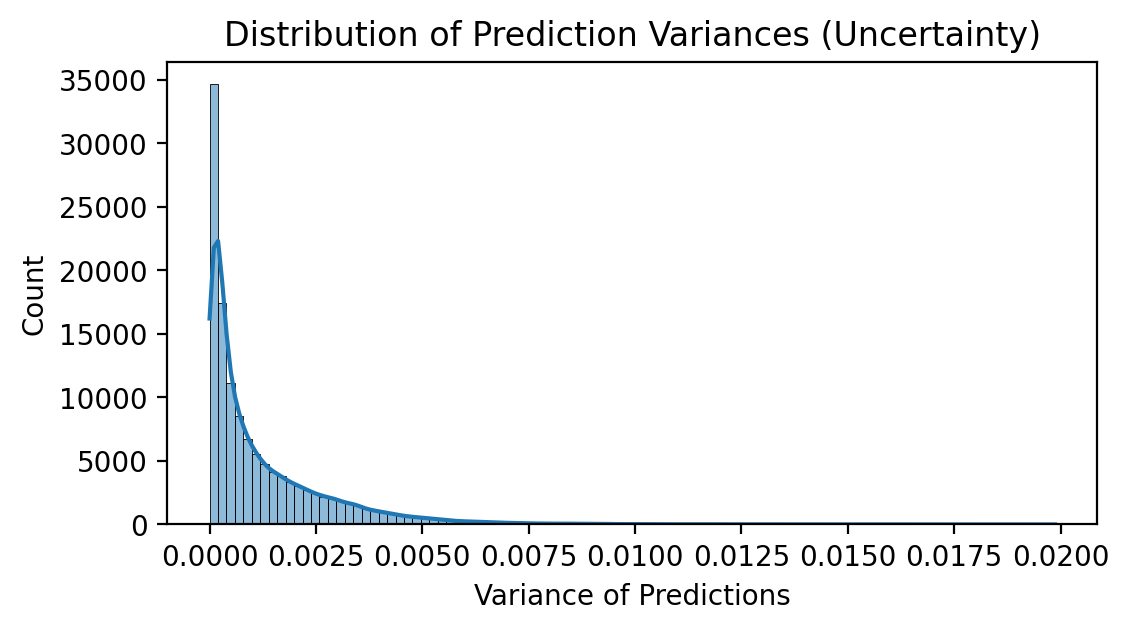

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. Distribution of Prediction Uncertainties
# limit the values between 0 and 0.02 for train_res['var_p']
plt.figure(figsize=(6, 3))
sns.histplot(train_res[train_res['var_p'] < 0.02]['var_p'], bins=100, kde=True)
plt.title('Distribution of Prediction Variances (Uncertainty)')
plt.xlabel('Variance of Predictions')
plt.ylabel('Count')
plt.show()

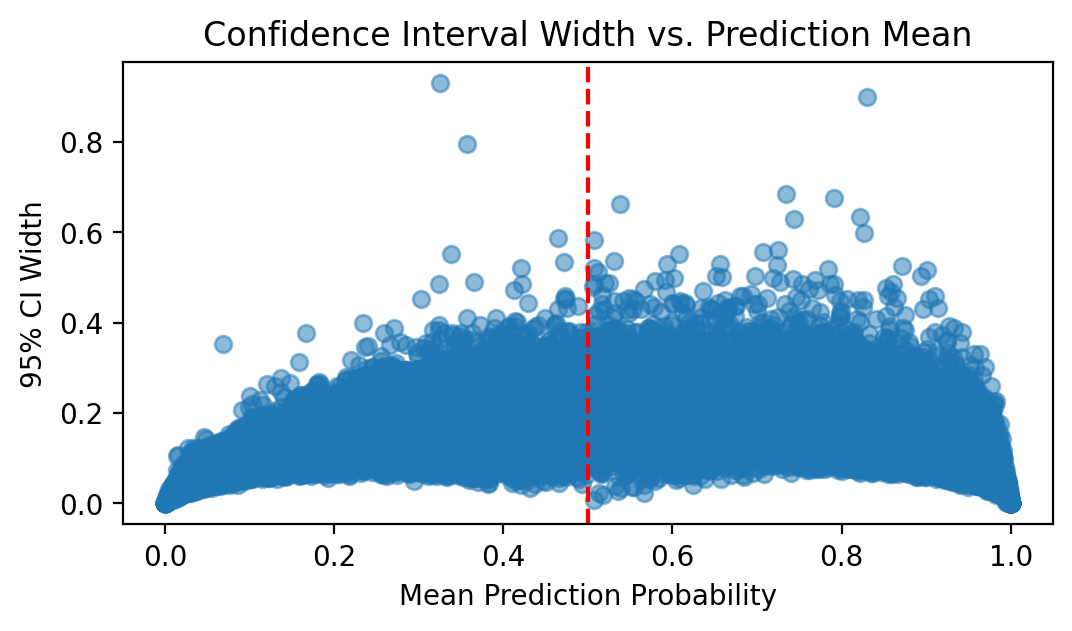

In [ ]:
# 2. Confidence Interval Width vs. Prediction Mean
plt.figure(figsize=(6, 3))
ci_width = train_res['ci_upper'] - train_res['ci_lower']
plt.scatter(train_res['mean_p'], ci_width, alpha=0.5)
plt.title('Confidence Interval Width vs. Prediction Mean')
plt.xlabel('Mean Prediction Probability')
plt.ylabel('95% CI Width')
plt.axvline(0.5, color='red', linestyle='--')
plt.show()

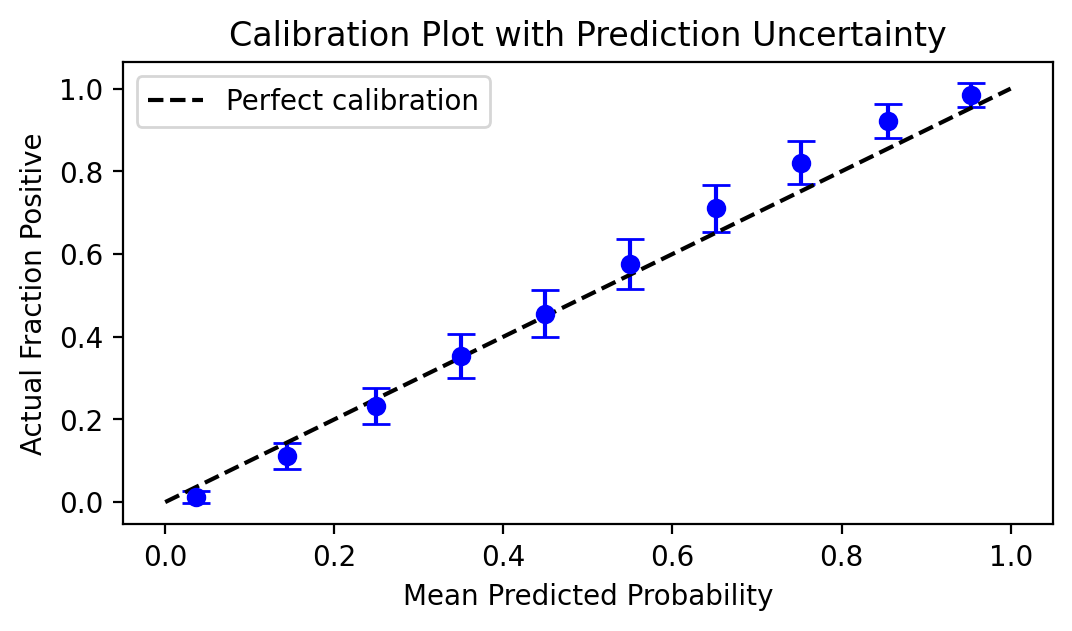

In [ ]:
# 3. Calibration Plot with Uncertainty
plt.figure(figsize=(6, 3))
bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_means = []
bin_variances = []

for i in range(len(bins)-1):
    mask = (train_res['mean_p'] >= bins[i]) & (train_res['mean_p'] < bins[i+1])
    bin_data = train_res[mask]
    if len(bin_data) > 0:
        # Actual fraction of positive class
        actual_frac = np.mean(bin_data['true_label'])
        # Average predicted probability
        mean_pred = np.mean(bin_data['mean_p'])
        # Average variance
        mean_var = np.mean(bin_data['var_p'])

        plt.errorbar(mean_pred, actual_frac, yerr=np.sqrt(mean_var),
                    fmt='o', capsize=5, color='blue')

plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
plt.title('Calibration Plot with Prediction Uncertainty')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Actual Fraction Positive')
plt.legend()
plt.show()

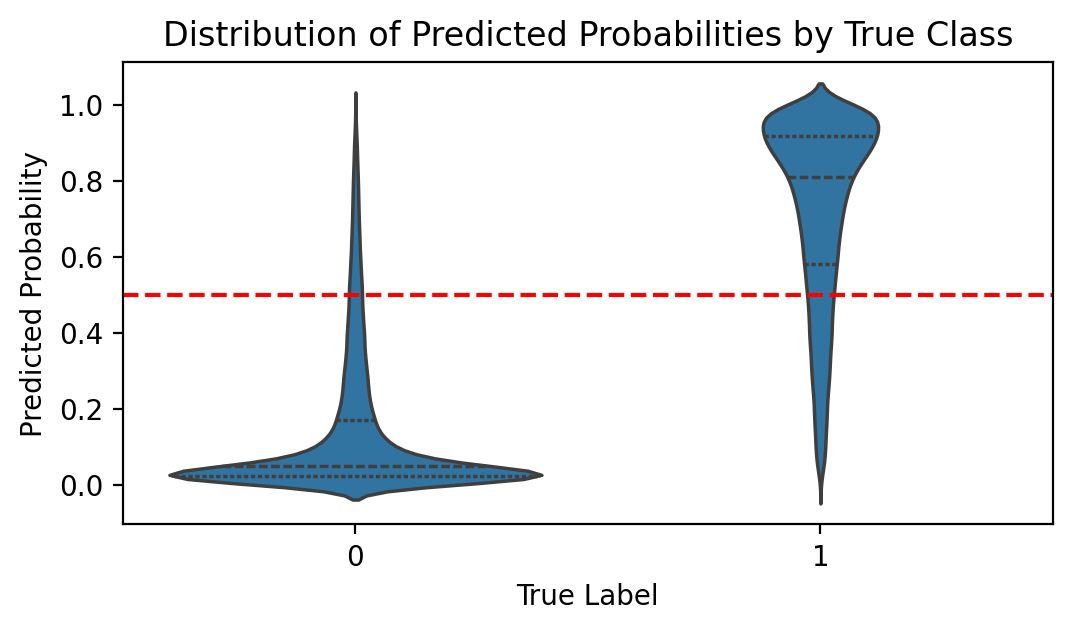

In [ ]:
# 4. Violin Plots of Prediction Distributions by True Class
plt.figure(figsize=(6, 3))
sns.violinplot(x='true_label', y='mean_p', data=train_res, inner="quartile")
plt.title('Distribution of Predicted Probabilities by True Class')
plt.xlabel('True Label')
plt.ylabel('Predicted Probability')
plt.axhline(0.5, color='red', linestyle='--')
plt.show()

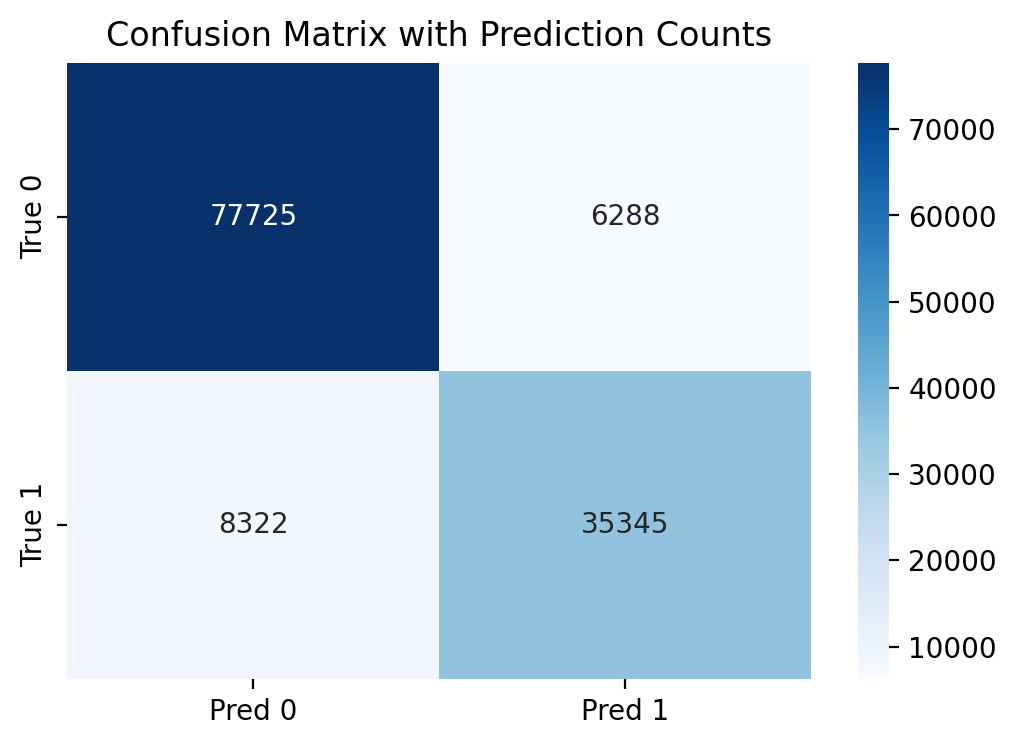

In [ ]:
# 5. Uncertainty Heatmap by Prediction and True Label
plt.figure(figsize=(6, 4))
train_res['predicted_label'] = np.round(train_res['mean_p'])
conf_mat = confusion_matrix(train_res['true_label'], train_res['predicted_label'])
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Pred 0', 'Pred 1'],
           yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix with Prediction Counts')
plt.show()

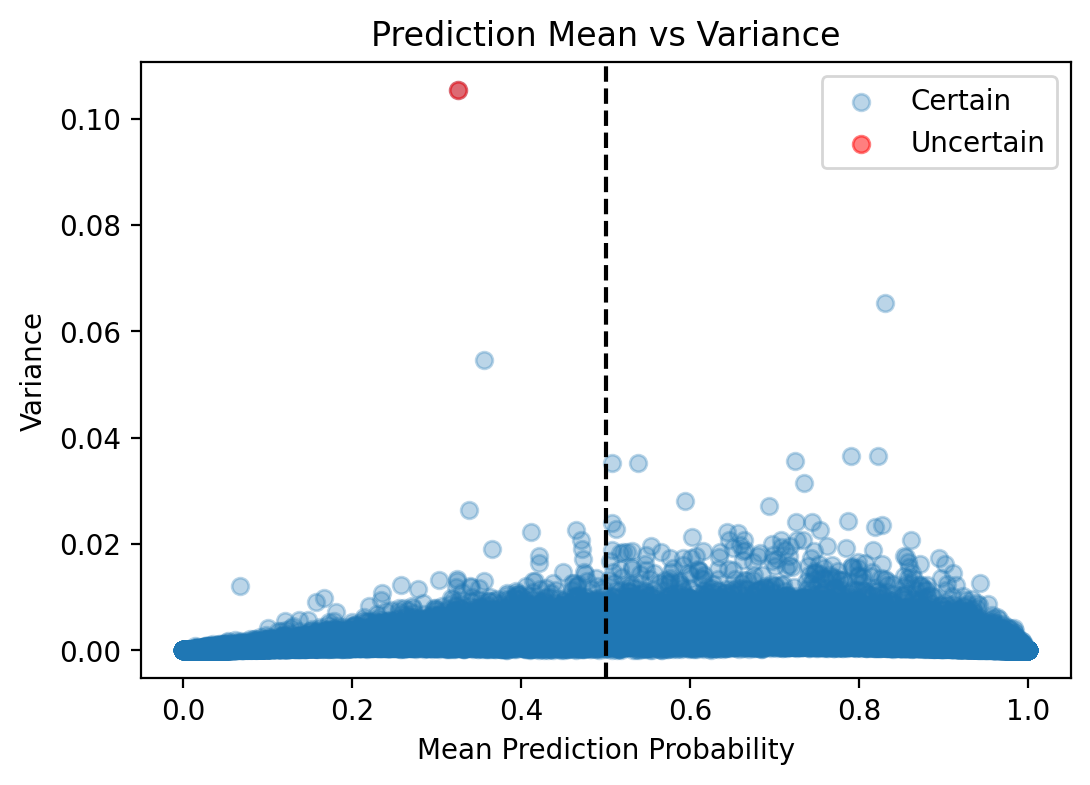

In [ ]:
# 6. Most Uncertain Predictions Analysis
uncertain_threshold = 0.1  # Variance threshold for uncertain predictions
uncertain = train_res[train_res['var_p'] > uncertain_threshold]

plt.figure(figsize=(6, 4))
plt.scatter(train_res['mean_p'], train_res['var_p'], alpha=0.3, label='Certain')
plt.scatter(uncertain['mean_p'], uncertain['var_p'], color='red', alpha=0.5, label='Uncertain')
plt.title('Prediction Mean vs Variance')
plt.xlabel('Mean Prediction Probability')
plt.ylabel('Variance')
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.show()

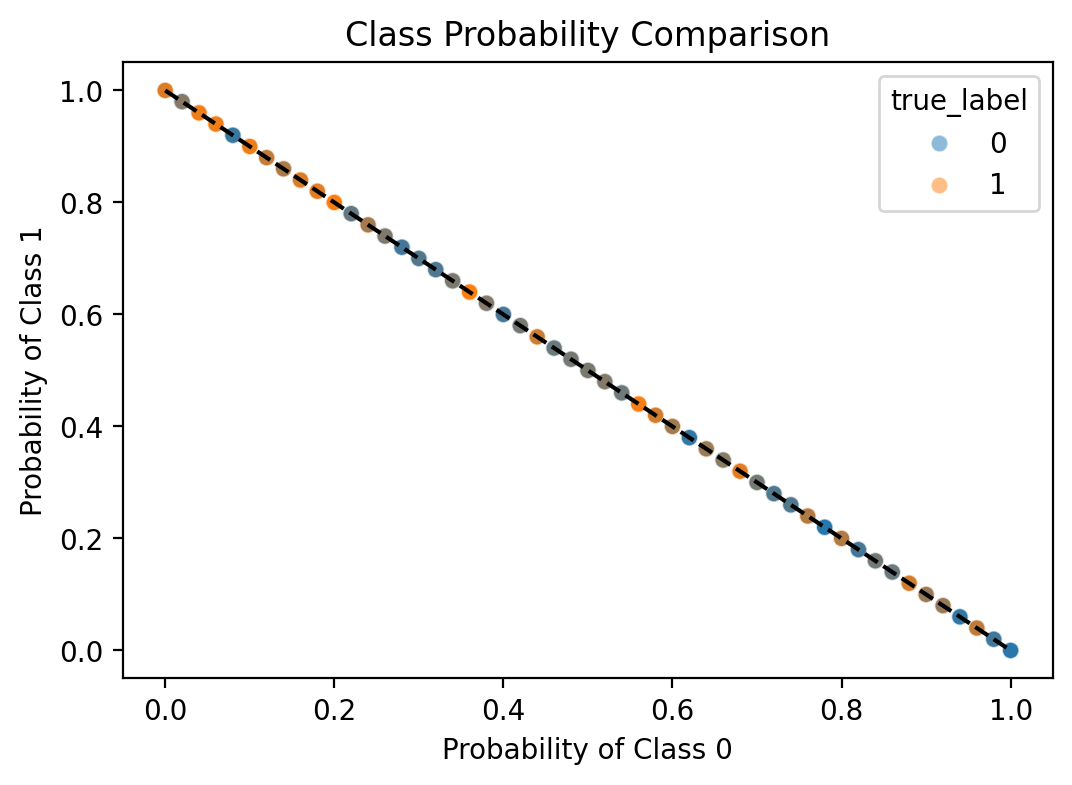

In [ ]:
# 7. Class Probability Comparison
plt.figure(figsize=(6, 4))
sns.scatterplot(x='prob0', y='prob1', hue='true_label', data=train_res, alpha=0.5)
plt.title('Class Probability Comparison')
plt.xlabel('Probability of Class 0')
plt.ylabel('Probability of Class 1')
plt.plot([0, 1], [1, 0], 'k--')  # Diagonal line
plt.show()

In [ ]:
# Assuming train_index contains the original indices for the training set
# And train_loader is your DataLoader with drop_last=True

train_dataset = train_loader.dataset
batch_size = train_loader.batch_size
num_samples_in_loader = len(train_loader) * batch_size

# Calculate the average scores for each row across all columns in train_save_out
#average_scores = np.mean(train_save_out, axis=1)
#print("Shape of average scores:", average_scores.shape)

# Get the indices that are included in the DataLoader after dropping the last batch
included_train_indices = train_index[:num_samples_in_loader]

print("Original train indices:", train_index)
print("Indices included in the train DataLoader (after dropping last batch):", included_train_indices)

train_results_df = pd.DataFrame({
    'index': included_train_indices
})
print(train_results_df.shape)
# column bind train_results_df with train_res
train_results_df = pd.concat([train_results_df, train_res], axis=1)
print(train_results_df.shape)

# Merge back with your full dataset (ds) on 'index' with ds.Column1
merged_train_results = train_results_df.merge(ds, on='index', how='left')

# save the data frame train_res to csv file
merged_train_results.to_csv('/content/drive/MyDrive/AMIC project/data/train_uncertainty.csv')

print("Merged DataFrame:")
print(merged_train_results.shape)
# Inspect
merged_train_results

In [ ]:
merged_train_results[['Clean_desc', 'true_label', 'model_output']]

,Clean_desc,true_label
0,NaN,1
1,NaN,1
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
127675,Smoke and tobacco notes wreath cherry and plum...,0
127676,NaN,1
127677,NaN,0
127678,"Simple, with modest ripe pear, melon and hazel...",1



## Prediction on validation set

In [ ]:
%%time
validation_losses = [] # track loss
num_correct = 0
mb1.eval()
mb2.eval()
mb3.eval()
mb0.eval()

# iterate over val data
test_mask=[]
outcome = []
masks = []

train_on_gpu = True
use_mask = True

criterion = nn.BCELoss()

val_word_pred = np.zeros((pad_embedding_matrix.shape[0],2))
val_mask_counter  = np.zeros((pad_embedding_matrix.shape[0],2))

val_word_dist =[[] for x in range(pad_embedding_matrix.shape[0])]
val_mask_dist = [[] for x in range(pad_embedding_matrix.shape[0])]

val_word_dist_rat0 =[[] for x in range(pad_embedding_matrix.shape[0])]
val_mask_dist_rat0 = [[] for x in range(pad_embedding_matrix.shape[0])]

val_word_dist_rat1 =[[] for x in range(pad_embedding_matrix.shape[0])]
val_mask_dist_rat1 = [[] for x in range(pad_embedding_matrix.shape[0])]

results = []
all_predictions = []
all_means = []
all_vars  = []


if(train_on_gpu):
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)


for batch_i,(inputs, labels) in enumerate(valid_loader):
    if batch_i % 20 == 0:
        print(f"begin batch {batch_i}")
    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).to(device)

    texts, digits = inputs[:,0:pad_size], inputs[:,pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

    embeds, mask_1= mb0(texts)
    mask_out, p1, p3, mean_mask = mb2(embeds,mask_1, digits)
    sent_out, save_out_sent, save_out0_sent = mb1(embeds,mask_1, mask_out, digits)
    output, p2, save_out = mb3(sent_out, digits, mask_out,use_mask )

    # apply the function mc_dropout_predict() mb3
    a_p, m_p, v_p = mc_dropout_predict(model=mb3, sent=sent_out, digits=digits, mask=mask_out, use_mask=use_mask, T=50, device=device)

    # 3) move everything to CPU/NumPy
    samples_np = a_p.detach().cpu().numpy()      # shape (T, B)
    det_out_np = output.detach().cpu().numpy()   # shape (B,)
    labels_np  = labels.detach().cpu().numpy()   # shape (B,)

    # 4) loop over each example in the batch
    B = samples_np.shape[1]
    for i in range(B):
        samp_i = samples_np[:, i]             # (T,)
        stats  = summarize_mc_samples(samp_i) # dict with mean_p, var_p, ci_95%, prob1, etc.

        row = {
            'true_label':   labels_np[i],
            'model_output': det_out_np[i],
            'mean_p':       stats['mean_p'],
            'var_p':        stats['var_p'],
            'ci_lower':     stats['ci_95%'][0],
            'ci_upper':     stats['ci_95%'][1],
            'prob1':        stats['prob1'],
            'prob0':        stats['prob0'],
            'mean_label':   stats['label'],
            'certain':      stats['certain?']
        }
        results.append(row)

    # collect
    all_predictions.append(a_p.cpu().detach().numpy())
    all_means.append(m_p.cpu().detach().numpy())
    all_vars.append(v_p.cpu().detach().numpy())

    mask_out = mask_out.detach()

    mask_out = mask_out.detach().to('cpu').numpy()
    norms = torch.norm(save_out,p=1,dim = 1).pow(0.5).detach().cpu().numpy()  #normalize sentiment output by sqrt of sentence l1
    save_out = save_out.detach().to('cpu').numpy()
    inputs_tmp = inputs.to('cpu').numpy()


    sums = 0
    word_c = 0
    for b_i in range(mask_out.shape[0]):
        length = digits[b_i,digits_dim -1].to('cpu').numpy()
        word_c += length
        tmp = mask_out[b_i][(pad_size - length - 1):pad_size]
        sums += np.sum(tmp)

    mean_mask1 = sums / word_c

#     for id1, doc in enumerate(inputs_tmp[:,:100]):
#         for id2, word in enumerate(doc):
#             val_word_pred[word,0] += save_out[id1,id2]
#             val_word_pred[word,1] += 1

#             if mask_out[id1,id2]>0.5:
#                 val_mask_counter[word,0] +=  1
#             else:
#                 val_mask_counter[word,1] +=  1

#             val_word_dist[word].append(save_out[id1,id2])
#             val_mask_dist[word].append(mask_out[id1,id2])

#             if labels[id1] == 0:
#               val_word_dist_rat0[word].append(save_out[id1,id2])
#               val_mask_dist_rat0[word].append(mask_out[id1,id2])
#             else:
#               val_word_dist_rat1[word].append(save_out[id1,id2])
#               val_mask_dist_rat1[word].append(mask_out[id1,id2])


    masks.append(mean_mask1)

    # calculate loss
    validation_loss = criterion(output.squeeze(), labels.float())
    validation_losses.append(validation_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    outcome.extend(pred.detach().to('cpu').numpy())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Validation loss: {:.4f}".format(np.mean(validation_losses)))
print("Mean_mask: {:.4f}".format(np.mean(masks)))
# accuracy over all test data
validation_acc = num_correct/(len(valid_loader.dataset)//batch_size * batch_size)
print("Validation accuracy: {:.4f}".format(validation_acc))

# … after your loop finishes …
val_res = pd.DataFrame(results)
print(val_res.head())

# Save val_res
val_res.to_csv('/content/drive/MyDrive/AMIC project/data/val_uncertainty.csv')

begin batch 0
begin batch 20
begin batch 40
begin batch 60
begin batch 80
begin batch 100
Validation loss: 0.2882
Mean_mask: 0.0669
Validation accuracy: 0.8760
   true_label  model_output    mean_p     var_p  ci_lower  ci_upper  prob1  \
0           0      0.065700  0.067286  0.000407  0.041268  0.107272   0.00   
1           0      0.023766  0.024425  0.000091  0.011804  0.047316   0.00   
2           0      0.006868  0.007446  0.000018  0.002833  0.017767   0.00   
3           1      0.871350  0.869922  0.001330  0.787542  0.913863   1.00   
4           1      0.481648  0.476610  0.007208  0.304778  0.581502   0.54   

   prob0  mean_label  certain  
0   1.00           0     True  
1   1.00           0     True  
2   1.00           0     True  
3   0.00           1     True  
4   0.46           0    False  
CPU times: user 2.96 s, sys: 28.1 ms, total: 2.98 s
Wall time: 2.97 s


## Prediction on the test set

V_0_* :mask applied before sentiment attention
V_1_*: mask applied after sentiemnt attention
V_2_*: no attention for masking block

without premasking in sentiemnt block

v_1_0
Test loss: 0.2541
Mean_mask: 0.2575
Test accuracy: 0.8863

v_1_1

Test loss: 0.2541
Mean_mask: 0.2575
Test accuracy: 0.8863

oss_p = loss + torch.mean(p1*0.001).squeeze()+ torch.mean(p3*0.002)  +(torch.mean(p2*0.00015)).squeeze()

V0
Test loss: 0.2540
Mean_mask: 0.2522
Test accuracy: 0.8870

v1
Test loss: 0.2541
Mean_mask: 0.2461
Test accuracy: 0.8867

V2

Test loss: 0.2592
Mean_mask: 0.0973
Test accuracy: 0.8853
torch.mean(p1*0.01).squeeze()+ torch.mean(p3*0.03).squeeze() + (torch.mean(p4*0.00015)).squeeze() +(torch.mean(p2*0.00015)).squeeze()

V3

Test loss: 0.2592
Mean_mask: 0.0973
Test accuracy: 0.8853
 torch.mean(p1*0.0015).squeeze()+ torch.mean(p3*0.03).squeeze() + (torch.mean(p4*0.00015)).squeeze() +(torch.mean(p2*0.00015)).squeeze()

v4
Test loss: 0.3071
Mean_mask: 0.2602
Test accuracy: 0.8874
loss_p = loss + torch.mean(p1*0.01).squeeze()+ torch.mean(p3*0.02)  +(torch.mean(p2*0.0015)).squeeze() + (torch.mean(p4*0.001)).squeeze() +(torch.mean(p2*0.001)).squeeze()


In [ ]:
%%time
test_losses = [] # track loss
num_correct = 0
mb1.eval()
mb2.eval()
mb3.eval()
mb0.eval()

# iterate over test data
test_mask=[]
outcome = []
y_labels = []
masks = []

train_on_gpu = True
use_mask = True

criterion = nn.BCELoss()

test_word_pred = np.zeros((pad_embedding_matrix.shape[0],2))
test_value_pred = np.zeros((pad_embedding_matrix.shape[0],2))

test_mask_counter  = np.zeros((pad_embedding_matrix.shape[0],2))

test_word_dist =[[] for x in range(pad_embedding_matrix.shape[0])]
test_mask_dist = [[] for x in range(pad_embedding_matrix.shape[0])]

test_word_dist_rat0 =[[] for x in range(pad_embedding_matrix.shape[0])]
test_mask_dist_rat0 = [[] for x in range(pad_embedding_matrix.shape[0])]

test_word_dist_rat1 =[[] for x in range(pad_embedding_matrix.shape[0])]
test_mask_dist_rat1 = [[] for x in range(pad_embedding_matrix.shape[0])]

# create an 2d empty numpy array to collect each batch save_out into one container
test_save_out = np.zeros((len(test_loader.dataset), pad_size))

results = []
all_predictions = []
all_means = []
all_vars  = []

if(train_on_gpu):
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)


for batch_i,(inputs, labels) in enumerate(test_loader):
    if batch_i %20 == 0:
        print(f"begin batch {batch_i}")
    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).to(device)

    texts, digits = inputs[:,0:pad_size], inputs[:,pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

    embeds , mask_1= mb0(texts)
    mask_out, p1,p3, mean_mask = mb2(embeds,mask_1, digits)
    sent_out, save_out_sent, save_out0_sent = mb1(embeds,mask_1, mask_out, digits)
    output , p2, save_out = mb3(sent_out, digits, mask_out,use_mask )

    # apply the function mc_dropout_predict() mb3
    a_p, m_p, v_p = mc_dropout_predict(model=mb3, sent=sent_out, digits=digits, mask=mask_out, use_mask=use_mask, T=50, device=device)

    # 3) move everything to CPU/NumPy
    samples_np = a_p.detach().cpu().numpy()      # shape (T, B)
    det_out_np = output.detach().cpu().numpy()   # shape (B,)
    labels_np  = labels.detach().cpu().numpy()   # shape (B,)

    # 4) loop over each example in the batch
    B = samples_np.shape[1]
    for i in range(B):
        samp_i = samples_np[:, i]             # (T,)
        stats  = summarize_mc_samples(samp_i) # dict with mean_p, var_p, ci_95%, prob1, etc.

        row = {
            'true_label':   labels_np[i],
            'model_output': det_out_np[i],
            'mean_p':       stats['mean_p'],
            'var_p':        stats['var_p'],
            'ci_lower':     stats['ci_95%'][0],
            'ci_upper':     stats['ci_95%'][1],
            'prob1':        stats['prob1'],
            'prob0':        stats['prob0'],
            'mean_label':   stats['label'],
            'certain':      stats['certain?']
        }
        results.append(row)

    # collect
    all_predictions.append(a_p.cpu().detach().numpy())
    all_means.append(m_p.cpu().detach().numpy())
    all_vars.append(v_p.cpu().detach().numpy())

    mask_out = mask_out.detach()
    values_out  = mask_out.detach().to('cpu').numpy()
    mask_out = mask_out.detach().to('cpu').numpy()
    norms = torch.norm(save_out,p=1,dim = 1).pow(0.5).detach().cpu().numpy()  #normalize sentiment output by sqrt of sentence l1
    save_out = save_out.detach().to('cpu').numpy()
    inputs_tmp = inputs.to('cpu').numpy()
    # stack each batch save_out into the test_save_out
    test_save_out[batch_i*batch_size:(batch_i+1)*batch_size,0:pad_size] = save_out


    sums = 0
    word_c = 0
    for b_i in range(mask_out.shape[0]):
        length = digits[b_i,digits_dim -1].to('cpu').numpy()
        word_c += length
        tmp = mask_out[b_i][(pad_size - length - 1):pad_size]
        sums += np.sum(tmp)

    mean_mask1 = sums / word_c

    for id1, doc in enumerate(inputs_tmp[:,:100]):
        for id2, word in enumerate(doc):
            test_word_pred[word,0] += save_out[id1,id2]
            test_word_pred[word,1] += 1

            test_value_pred[word,0] += values_out[id1,id2]
            test_value_pred[word,1] += 1

            if mask_out[id1,id2]>0.5:
                test_mask_counter[word,0] +=  1
            else:
                test_mask_counter[word,1] +=  1

            test_word_dist[word].append(save_out[id1,id2])
            test_mask_dist[word].append(mask_out[id1,id2])

            if labels[id1] == 0:
                test_word_dist_rat0[word].append(save_out[id1,id2])
                test_mask_dist_rat0[word].append(mask_out[id1,id2])
            else:
                test_word_dist_rat1[word].append(save_out[id1,id2])
                test_mask_dist_rat1[word].append(mask_out[id1,id2])


    masks.append(mean_mask1)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    outcome.extend(pred.detach().to('cpu').numpy())
    y_labels.extend(labels.float().cpu().numpy())
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.4f}".format(np.mean(test_losses)))
print("Mean_mask: {:.4f}".format(np.mean(masks)))
# accuracy over all test data
test_acc = num_correct/(len(test_loader.dataset)//batch_size * batch_size)
print("Test accuracy: {:.4f}".format(test_acc))

# … after your loop finishes …
test_res = pd.DataFrame(results)
print(test_res.head())

# Save val_res
val_res.to_csv('/content/drive/MyDrive/AMIC project/data/test_uncertainty.csv')

begin batch 0
begin batch 20
begin batch 40
begin batch 60
begin batch 80
begin batch 100
Test loss: 0.2845
Mean_mask: 0.0666
Test accuracy: 0.8822
   true_label  model_output    mean_p     var_p  ci_lower  ci_upper  prob1  \
0           1      0.935632  0.929638  0.000852  0.852285  0.963383    1.0   
1           1      0.357479  0.363037  0.002805  0.257835  0.449483    0.0   
2           0      0.171720  0.177648  0.000687  0.132445  0.240988    0.0   
3           0      0.031886  0.034225  0.000182  0.016832  0.065272    0.0   
4           0      0.007867  0.007782  0.000020  0.003113  0.017918    0.0   

   prob0  mean_label  certain  
0    0.0           1     True  
1    1.0           0     True  
2    1.0           0     True  
3    1.0           0     True  
4    1.0           0     True  
CPU times: user 33.8 s, sys: 106 ms, total: 33.9 s
Wall time: 33.8 s
